## Importing Libraries

In [263]:
%matplotlib inline
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pylab
import matplotlib.pyplot as plt
import scipy.stats as stats
import datetime
import itertools

import sklearn
from sklearn.preprocessing import PowerTransformer
from scipy.stats import boxcox 

import statsmodels
import statsmodels.api as sm
from statsmodels.tsa.stattools import coint, adfuller, kpss
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.stattools import acf, pacf

import warnings
from math import sqrt
from pandas import read_csv
from statsmodels.tsa.arima.model import ARIMA
from sklearn.metrics import mean_squared_error
from statsmodels.tsa.ar_model import AutoReg
import pmdarima as pm

from statsmodels.tsa.holtwinters import SimpleExpSmoothing
from statsmodels.tsa.holtwinters import Holt
from statsmodels.tsa.holtwinters import ExponentialSmoothing

from sklearn.preprocessing import MinMaxScaler
from keras.preprocessing.sequence import TimeseriesGenerator
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from keras.layers import Dropout

from pandas.tseries.offsets import DateOffset
import warnings
warnings.filterwarnings("ignore") # specify to ignore warning messages


In [334]:
df = pd.read_csv("co-emissions-by-sector.csv")
df=df[['Year', 'Buildings']]
df.to_csv("CO2_data_buildings.csv")

In [335]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 29 entries, 0 to 28
Data columns (total 2 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   Year       29 non-null     int64  
 1   Buildings  29 non-null     float64
dtypes: float64(1), int64(1)
memory usage: 592.0 bytes


In [336]:
dateparse = lambda x: pd.to_datetime(x, format='%Y', errors = 'coerce')
df = pd.read_csv("CO2_data_buildings.csv",parse_dates=['Year'], index_col='Year', date_parser=dateparse) 
df=df.drop('Unnamed: 0',axis=1)
df.rename({'Buildings':'CO2'},axis=1,inplace=True)
df.head()


,CO2
Year,
1990-01-01,0.54548
1991-01-01,0.55520
1992-01-01,0.56508
1993-01-01,0.58559
1994-01-01,0.57586


<AxesSubplot:xlabel='CO2'>

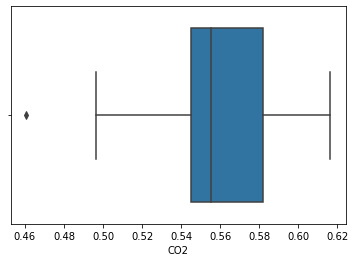

In [337]:
sns.boxplot(df['CO2'])

<AxesSubplot:xlabel='Year'>

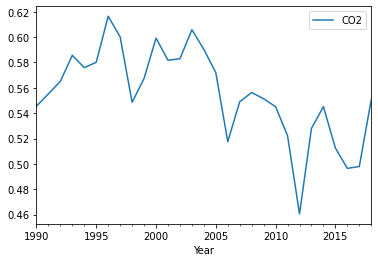

In [338]:
df.plot()

## Transforming data to normal distribution

In [339]:
def diagnostic_plots(df, variable):
    # function to plot a histogram and a Q-Q plot
    # side by side, for a certain variable
    
    plt.figure(figsize=(15,6))
    plt.subplot(1, 2, 1)
    df[variable].hist()

    plt.subplot(1, 2, 2)
    stats.probplot(df[variable], dist="norm", plot=plt)

    plt.show()
    

### Log Transformation

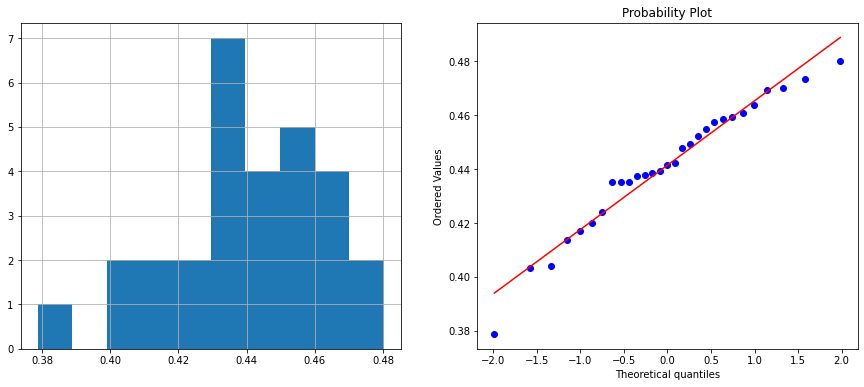

In [340]:
df['Log_co2']=np.log(df['CO2']+1)
diagnostic_plots(df,'Log_co2')

### Reciprocal Transformation

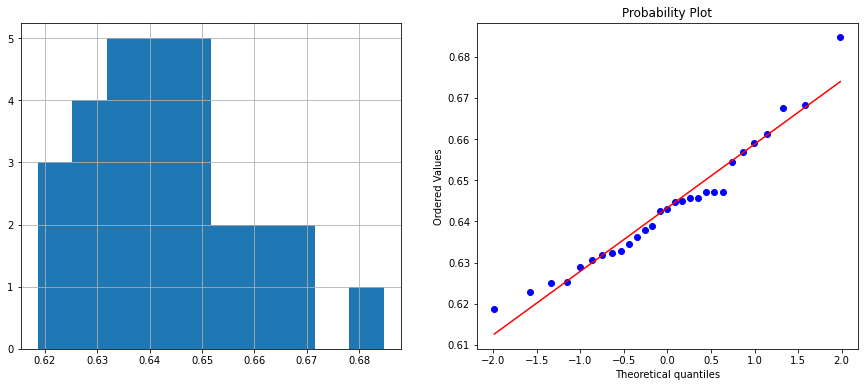

In [341]:
df['Rec_co2']=1/(df['CO2']+1)
diagnostic_plots(df,'Rec_co2')

### Square-Root Transformation

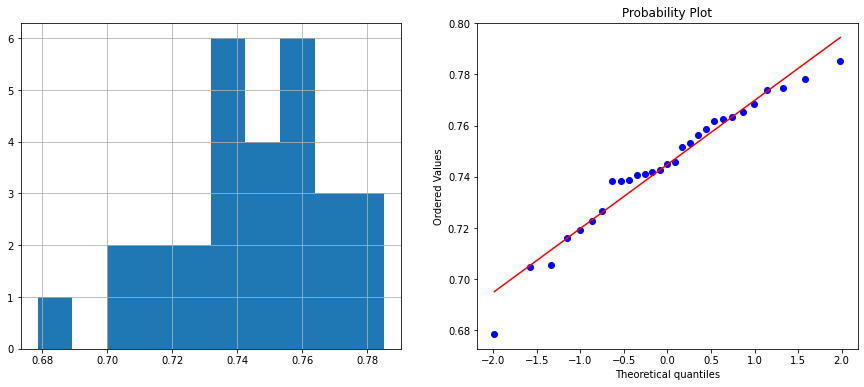

In [342]:
df['sqr_co2']=df['CO2']**(1/2)
diagnostic_plots(df,'sqr_co2')

### Exponential Transformation

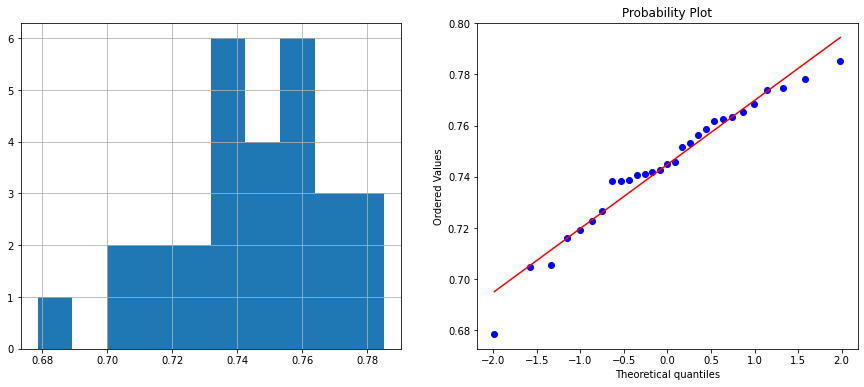

In [343]:
df['Exp_co2']=df['CO2']**(1/5)
diagnostic_plots(df,'sqr_co2')

### Box-cox Transformation

Optimal lambda:  10.813591090606588


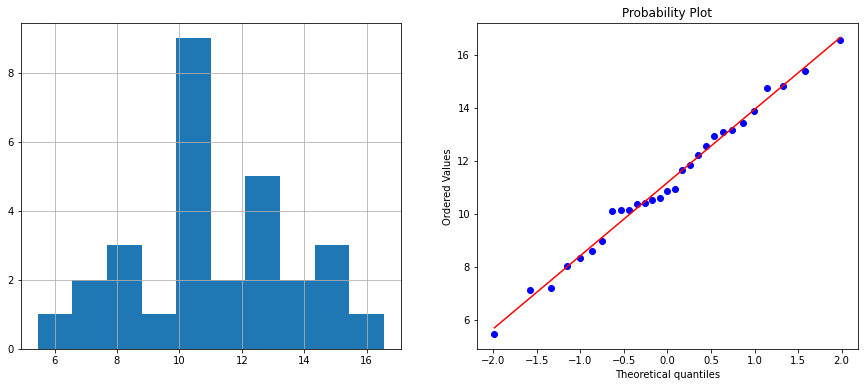

In [344]:
df['co2_boxcox'], param = stats.boxcox(df.CO2+1) # you can vary the exponent as needed

print('Optimal lambda: ', param)

diagnostic_plots(df, 'co2_boxcox')

array([[-0.38933687, -0.38915077,  0.39024981, -0.38933687, -0.38933688,
        -0.39016937],
       [-0.11357799, -0.11294083,  0.1157224 , -0.11357798, -0.113578  ,
        -0.11563586],
       [ 0.18410831,  0.18507557, -0.1811253 ,  0.18410832,  0.18410831,
         0.18120402],
       [ 0.86135656,  0.86215862, -0.85916285,  0.86135656,  0.86135656,
         0.85917253],
       [ 0.52980038,  0.53086516, -0.52669286,  0.52980038,  0.52980037,
         0.52674487],
       [ 0.67059686,  0.67159614, -0.66774481,  0.67059686,  0.67059686,
         0.66778079],
       [ 2.04205863,  2.03840492, -2.05315578,  2.04205861,  2.04205865,
         2.05289401],
       [ 1.39117121,  1.39070209, -1.39287248,  1.3911712 ,  1.39117122,
         1.39278271],
       [-0.30318801, -0.30284974,  0.30452298, -0.303188  , -0.30318802,
        -0.3044392 ],
       [ 0.25537404,  0.25638904, -0.2522842 ,  0.25537405,  0.25537404,
         0.25235892],
       [ 1.35507127,  1.35472471, -1.35640485,  1.

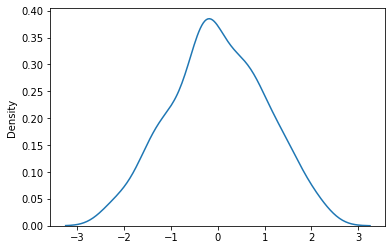

In [345]:

pt = PowerTransformer(method='box-cox')
data = pt.fit_transform(df)
sns.distplot(data, hist=False, kde=True)
data

<AxesSubplot:ylabel='Density'>

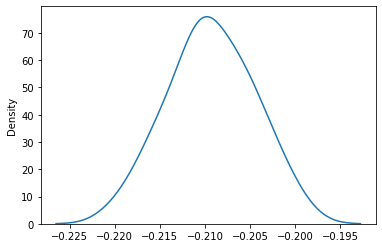

In [346]:

#perform Box-Cox transformation on original data
transformed_data, best_lambda = boxcox(df.CO2) 

#plot the distribution of the transformed data values
sns.distplot(transformed_data, hist=False, kde=True)

In [347]:
df.dtypes

CO2           float64
Log_co2       float64
Rec_co2       float64
sqr_co2       float64
Exp_co2       float64
co2_boxcox    float64
dtype: object

<AxesSubplot:xlabel='Year'>

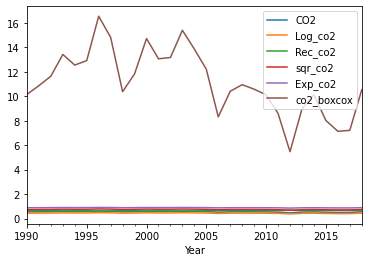

In [278]:
df.plot()

<AxesSubplot:xlabel='Year'>

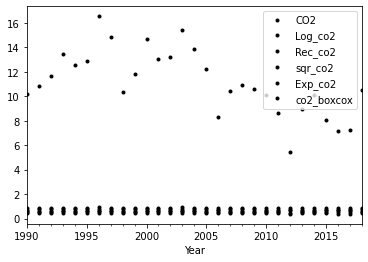

In [348]:
df.plot(style = 'k.')

In [349]:
df.describe()

,CO2,Log_co2,Rec_co2,sqr_co2,Exp_co2,co2_boxcox
count,29.00000,29.000000,29.000000,29.000000,29.000000,29.000000
mean,0.55531,0.441412,0.643299,0.744801,0.888712,11.173414
std,0.03616,0.023421,0.015181,0.024538,0.011798,2.664001
min,0.46055,0.378813,0.618663,0.678638,0.856358,5.467123
25%,0.54506,0.435063,0.632231,0.738282,0.885705,10.121805
50%,0.55520,0.441604,0.643004,0.745117,0.888976,10.870491
75%,0.58170,0.458500,0.647224,0.762693,0.897304,13.068158
max,0.61639,0.480195,0.684674,0.785105,0.907760,16.547891


array([[<AxesSubplot:title={'center':'CO2'}>,
        <AxesSubplot:title={'center':'Log_co2'}>],
       [<AxesSubplot:title={'center':'Rec_co2'}>,
        <AxesSubplot:title={'center':'sqr_co2'}>],
       [<AxesSubplot:title={'center':'Exp_co2'}>,
        <AxesSubplot:title={'center':'co2_boxcox'}>]], dtype=object)

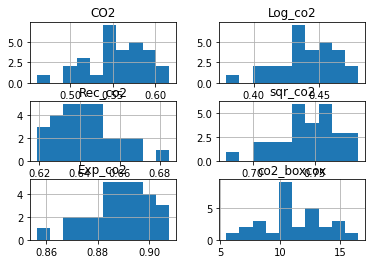

In [350]:
df.hist()

Since we didnot get any conclusive evidence of being normal distribution. We have decided to move on without transforming it to normal distribution.

#### Dropping all transformed values from dataset

In [351]:
df = df.drop(['co2_boxcox', 'Log_co2','Rec_co2','sqr_co2','Exp_co2'], axis = 1)

In [354]:
df.head(n=35)

,CO2
Year,
1990-01-01,0.54548
1991-01-01,0.55520
1992-01-01,0.56508
1993-01-01,0.58559
1994-01-01,0.57586
1995-01-01,0.58006
1996-01-01,0.61639
1997-01-01,0.60008
1998-01-01,0.54858


In [355]:
len(df)

29

In [284]:
df.dtypes

CO2    float64
dtype: object

In [285]:
df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 29 entries, 1990-01-01 to 2018-01-01
Data columns (total 1 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   CO2     29 non-null     float64
dtypes: float64(1)
memory usage: 464.0 bytes


<AxesSubplot:xlabel='Year'>

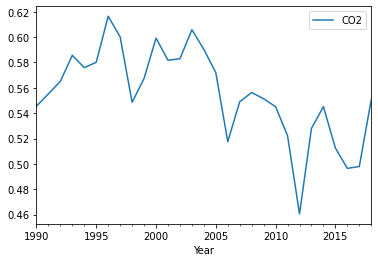

In [356]:
df.plot()

<AxesSubplot:xlabel='Year'>

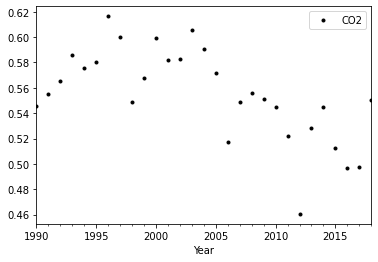

In [357]:
df.plot(style = 'k.')

Preliminary analysis of above plot says that there is presence of clear Level and Trend but we can't say about Seasonality right now.

In [358]:
df.describe()

,CO2
count,29.00000
mean,0.55531
std,0.03616
min,0.46055
25%,0.54506
50%,0.55520
75%,0.58170
max,0.61639


array([[<AxesSubplot:title={'center':'CO2'}>]], dtype=object)

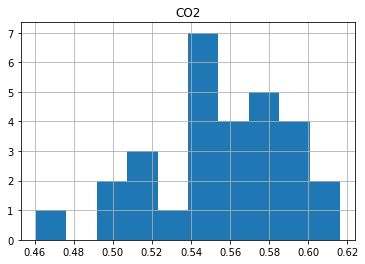

In [359]:
df.hist()

# A) MODEL BUILDING ON STATIONARY DATA

## Test Stationary

Naive test for stationary by checking constant mean and variance

In [360]:
X = df.values
split = round(len(X) / 2)
X1, X2 = X[0:split], X[split:]
mean1, mean2 = X1.mean(), X2.mean()
var1, var2 = X1.var(), X2.var()
print('mean1=%f, mean2=%f' % (mean1, mean2))
print('variance1=%f, variance2=%f' % (var1, var2))

mean1=0.579223, mean2=0.532992
variance1=0.000427, variance2=0.001010


Since mean and variance changes drastically it is evident that out data is not stationary. Let's confirm it using ADFuller test.

### Testing Stationary using ADFuller test

In [361]:
def TestStationaryPlot(df):
    rol_mean = df.rolling(window = 5, center = False).mean()
    rol_std = df.rolling(window = 5, center = False).std()
    
    plt.plot(df, color = 'blue',label = 'Original Data')
    plt.plot(rol_mean, color = 'red', label = 'Rolling Mean')
    plt.plot(rol_std, color ='black', label = 'Rolling Std')
    plt.xticks(fontsize = 10)
    plt.yticks(fontsize = 10)
    
    plt.xlabel('Time in Years', fontsize = 10)
    plt.ylabel('Total Emissions', fontsize = 10)
    plt.legend(loc='best', fontsize = 10)
    plt.title('Rolling Mean & Standard Deviation', fontsize = 10)
    plt.show(block= True)

In [362]:
# null Hypothesis : Data is stationary
#alternate hypothesis : Data is not stationary
def TestStationaryAdfuller(df, cutoff = 0.01):
    df_test = adfuller(df, autolag = 'AIC')
    df_test_output = pd.Series(df_test[0:4], index=['Test Statistic','p-value','#Lags Used','Number of Observations Used'])
    
    for key,value in df_test[4].items():
        df_test_output['Critical Value (%s)'%key] = value
    print(df_test_output)
    
    if df_test[1] <= cutoff:
        print("Failed to reject null hypothesis. Data is stationary")
    else:
        print("Failed to accept null hypothesis. Data is non-stationary ")
        

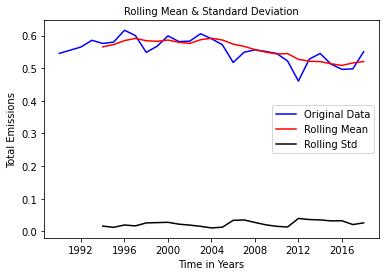

In [363]:
TestStationaryPlot(df)

In [364]:
TestStationaryAdfuller(df)

Test Statistic                 -2.326742
p-value                         0.163488
#Lags Used                      0.000000
Number of Observations Used    28.000000
Critical Value (1%)            -3.688926
Critical Value (5%)            -2.971989
Critical Value (10%)           -2.625296
dtype: float64
Failed to accept null hypothesis. Data is non-stationary 


The emissions mean and the variation in standard deviation (black line) clearly vary with time. This shows that the series has a trend. So, it is not a stationary. Also, the Test Statistic is greater than the critical values with 90%, 95% and 99% confidence levels. Hence, no evidence to accept the null hypothesis. Therefore the series is non stationary. 

## Transforming data to Stationary

Transforming data to stationary using three following methods:
- Moving Average
- Differencing
- Decomposing

### 1. Moving Average

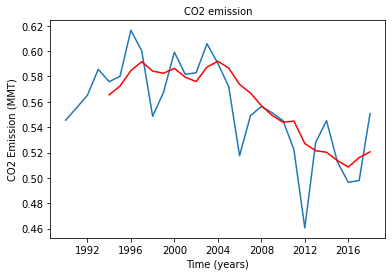

In [365]:
moving_avg = df.rolling(5).mean()
plt.plot(df)
plt.plot(moving_avg, color='red')
plt.xticks(fontsize = 10)
plt.yticks(fontsize = 10)
plt.xlabel('Time (years)', fontsize = 10)
plt.ylabel('CO2 Emission (MMT)', fontsize = 10)
plt.title('CO2 emission', fontsize = 10)
plt.show()

In [366]:
moving_avg_diff = df - moving_avg
moving_avg_diff.head(13)

,CO2
Year,
1990-01-01,NaN
1991-01-01,NaN
1992-01-01,NaN
1993-01-01,NaN
1994-01-01,0.010418
1995-01-01,0.007702
1996-01-01,0.031794
1997-01-01,0.008484
1998-01-01,-0.035614


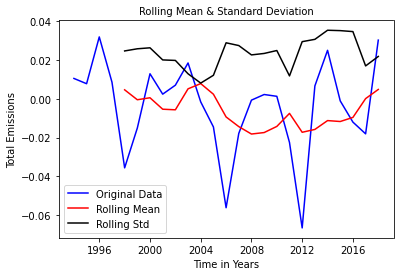

In [368]:
moving_avg_diff.dropna(inplace=True)
TestStationaryPlot(moving_avg_diff)

In [369]:
moving_avg.dropna(inplace=True)
TestStationaryAdfuller(moving_avg_diff)

Test Statistic                 -4.258457
p-value                         0.000524
#Lags Used                      1.000000
Number of Observations Used    23.000000
Critical Value (1%)            -3.752928
Critical Value (5%)            -2.998500
Critical Value (10%)           -2.638967
dtype: float64
Failed to reject null hypothesis. Data is stationary


The rolling mean values appear to be varying slightly. The Test Statistic is smaller than the 10% 5%, and 1% of critical values. So, we can say with 99% confidence level that the dataset is a stationary series.

### 2. Eliminating trend and seasonality: Differencing

One of the most common method of dealing with both trend and seasonality is differencing. In this technique, we take the difference of the original observation at a particular instant with that at the previous instant. This mostly works well to improve stationarity. First order differencing can be done as follows:

#### 2(A) : First order differencing

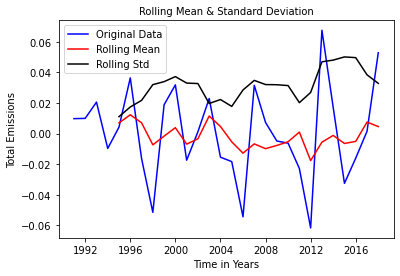

In [370]:
df_first_difference = df - df.shift(1)
#df_first_difference.head()
df.shift(1)
TestStationaryPlot(df_first_difference.dropna(inplace=False))


In [371]:
TestStationaryAdfuller(df_first_difference.dropna(inplace=False))

Test Statistic                 -4.569138
p-value                         0.000147
#Lags Used                      2.000000
Number of Observations Used    25.000000
Critical Value (1%)            -3.723863
Critical Value (5%)            -2.986489
Critical Value (10%)           -2.632800
dtype: float64
Failed to reject null hypothesis. Data is stationary


The first difference improves the stationarity of the series significantly. Let us use also the ***seasonal first order difference*** to remove the seasonality of the data and see how that impacts stationarity of the data.

#### 2(B) : Seasonal First order differencing

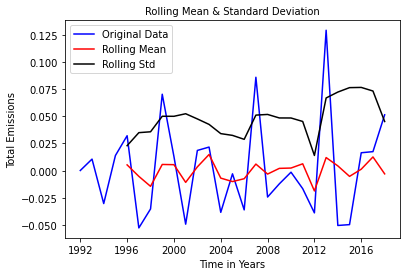

In [301]:
df_seasonal_first_difference = df_first_difference - df_first_difference.shift(1)  
TestStationaryPlot(df_seasonal_first_difference.dropna(inplace=False))

In [372]:
TestStationaryAdfuller(df_seasonal_first_difference.dropna(inplace=False))

Test Statistic                 -4.407666
p-value                         0.000288
#Lags Used                      4.000000
Number of Observations Used    22.000000
Critical Value (1%)            -3.769733
Critical Value (5%)            -3.005426
Critical Value (10%)           -2.642501
dtype: float64
Failed to reject null hypothesis. Data is stationary


We are considering this seasonal first difference for further analysis because it looks more stationary

### 3. Eliminating trend and seasonality: Decomposing

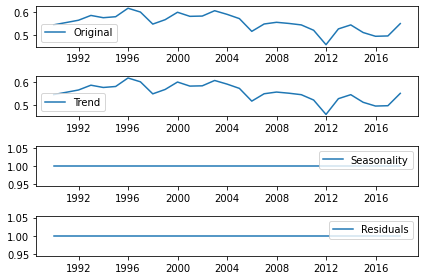

In [373]:
decomposition = seasonal_decompose(df,model="multiplicable")

trend = decomposition.trend
seasonal = decomposition.seasonal
residual = decomposition.resid

plt.subplot(411)
plt.plot(df, label='Original')
plt.legend(loc='best')
plt.subplot(412)
plt.plot(trend, label='Trend')
plt.legend(loc='best')
plt.subplot(413)
plt.plot(seasonal,label='Seasonality')
plt.legend(loc='best')
plt.subplot(414)
plt.plot(residual, label='Residuals')
plt.legend(loc='best')
plt.tight_layout()

Here we can see that the trend, no seasonaltiy in data and we can model the trend. Here original data and trend both are equal.

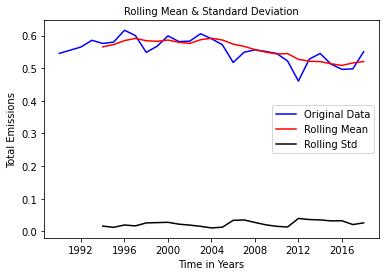

Test Statistic                 -2.326742
p-value                         0.163488
#Lags Used                      0.000000
Number of Observations Used    28.000000
Critical Value (1%)            -3.688926
Critical Value (5%)            -2.971989
Critical Value (10%)           -2.625296
dtype: float64
Failed to accept null hypothesis. Data is non-stationary 


In [374]:
df_decompose = trend
df_decompose.dropna(inplace=True)
TestStationaryPlot(df_decompose)
TestStationaryAdfuller(df_decompose)

## Plot the ACF and PACF charts and find the optimal parameters

* **Autocorrelation Function (ACF)**: It is a measure of the correlation between the the time series (ts) with a lagged version of itself.
* **Partial Autocorrelation Function (PACF)**: This measures the correlation between the ts with a lagged version of itself but after eliminating the variations already explained by the intervening comparisons.

In the next step we will be determing the tuning parameters (p and q) of the model by looking at the autocorrelation and partial autocorrelation plots.  The plot below provides a brief guide on how to read the autocorrelation and partial autocorrelation graphs inorder to select the parameters. 

### ACF & PACF plot for seasonal first order difference

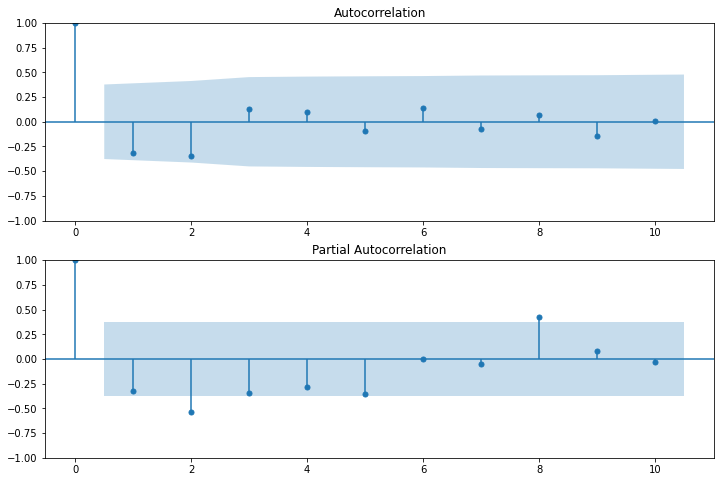

In [375]:
#ACF and PACF plots:
fig = plt.figure(figsize=(12,8))
ax1 = fig.add_subplot(211)
fig = sm.graphics.tsa.plot_acf(df_seasonal_first_difference.dropna(inplace=False), lags=10, ax=ax1)
ax2 = fig.add_subplot(212)
fig = sm.graphics.tsa.plot_pacf(df_seasonal_first_difference.dropna(inplace=False), lags=10, ax=ax2)

We will find optimal parameters (p,d,q) using grid search later

## Data Partitioning

- **Training Data** = Fit the model only to training period
- **Validating Data** = Assess the model performance on validation
- Deploy model by training on whole dataset
- No random partition That’s because the order sequence of the time series should be intact in order to use it for forecasting.

In [377]:
#using seasonal first order difference
df_seasonal_first_difference.head()

,CO2
Year,
1990-01-01,NaN
1991-01-01,NaN
1992-01-01,0.00016
1993-01-01,0.01063
1994-01-01,-0.03024


In [378]:
X = df_seasonal_first_difference.dropna(inplace=False)

In [380]:
X.head(n=30)

,CO2
Year,
1992-01-01,0.00016
1993-01-01,0.01063
1994-01-01,-0.03024
1995-01-01,0.01393
1996-01-01,0.03213
1997-01-01,-0.05264
1998-01-01,-0.03519
1999-01-01,0.07028
2000-01-01,0.01299


In [382]:
len(X)

27

In [383]:
# Create Training and Test
train = X.iloc[:20]
test = X.iloc[20:]

In [384]:
print(train.shape,test.shape)

(20, 1) (7, 1)


In [311]:
train.head()

,CO2
Year,
1992-01-01,0.00016
1993-01-01,0.01063
1994-01-01,-0.03024
1995-01-01,0.01393
1996-01-01,0.03213


In [312]:
test.head()

,CO2
Year,
2012-01-01,-0.03881
2013-01-01,0.12912
2014-01-01,-0.05039
2015-01-01,-0.04961
2016-01-01,0.01647


### Hyper-parameter Tuning : Finding out optimal (p,d,q)

In [385]:
# evaluate an ARIMA model for a given order (p,d,q)
def evaluate_arima_model(train, test, arima_order):
    history = [x for x in train]
    # make predictions
    predictions = list()
    for t in range(len(test)):
        model = ARIMA(history, order=arima_order)
        model_fit = model.fit()
        yhat = model_fit.forecast()[0]
        predictions.append(yhat)
        history.append(test[t])
    # calculate out of sample error
    rmse = sqrt(mean_squared_error(test, predictions))
    return rmse

In [386]:
# evaluate combinations of p, d and q values for an ARIMA model
def evaluate_models(train, test, p_values, d_values, q_values):
    #dataset = dataset.astype('float32')
    best_score, best_cfg = float("inf"), None
    for p in p_values:
        for d in d_values:
            for q in q_values:
                order = (p,d,q)
                try:
                    rmse = evaluate_arima_model(train, test, order)
                    if rmse < best_score:
                        best_score, best_cfg = rmse, order
                    print('ARIMA%s RMSE=%.3f' % (order,rmse))
                except:
                    continue
    print('Best ARIMA%s RMSE=%.3f' % (best_cfg, best_score))

In [387]:
# evaluate parameters
p_values = [0, 1, 2, 3, 4, 5]
d_values = range(0, 3)
q_values = range(0, 3)
warnings.filterwarnings("ignore")
evaluate_models(train.values, test.values, p_values, d_values, q_values)

ARIMA(0, 0, 0) RMSE=0.063
ARIMA(0, 0, 1) RMSE=0.048
ARIMA(0, 0, 2) RMSE=0.048
ARIMA(0, 1, 0) RMSE=0.097
ARIMA(0, 1, 1) RMSE=0.063
ARIMA(0, 1, 2) RMSE=0.046
ARIMA(0, 2, 0) RMSE=0.169
ARIMA(0, 2, 1) RMSE=0.100
ARIMA(0, 2, 2) RMSE=0.066
ARIMA(1, 0, 0) RMSE=0.061
ARIMA(1, 0, 1) RMSE=0.050
ARIMA(1, 0, 2) RMSE=0.051
ARIMA(1, 1, 0) RMSE=0.089
ARIMA(1, 1, 1) RMSE=0.061
ARIMA(1, 1, 2) RMSE=0.065
ARIMA(1, 2, 0) RMSE=0.138
ARIMA(1, 2, 1) RMSE=0.091
ARIMA(1, 2, 2) RMSE=0.097
ARIMA(2, 0, 0) RMSE=0.054
ARIMA(2, 0, 1) RMSE=0.044
ARIMA(2, 0, 2) RMSE=0.046
ARIMA(2, 1, 0) RMSE=0.075
ARIMA(2, 1, 1) RMSE=0.054
ARIMA(2, 1, 2) RMSE=0.043
ARIMA(2, 2, 0) RMSE=0.109
ARIMA(2, 2, 1) RMSE=0.077
ARIMA(2, 2, 2) RMSE=0.057
ARIMA(3, 0, 0) RMSE=0.051
ARIMA(3, 0, 1) RMSE=0.043
ARIMA(3, 0, 2) RMSE=0.044
ARIMA(3, 1, 0) RMSE=0.070
ARIMA(3, 1, 1) RMSE=0.051
ARIMA(3, 1, 2) RMSE=0.055
ARIMA(3, 2, 0) RMSE=0.100
ARIMA(3, 2, 1) RMSE=0.071
ARIMA(3, 2, 2) RMSE=0.075
ARIMA(4, 0, 0) RMSE=0.048
ARIMA(4, 0, 1) RMSE=0.045
ARIMA(4, 0, 

## ARIMA model

In [388]:
#2,1,2
model_arima = ARIMA(train['CO2'],order = (2,1,2))
model_arima = model_arima.fit()
model_arima.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                    CO2   No. Observations:                   20
Model:                 ARIMA(2, 1, 2)   Log Likelihood                  40.989
Date:                Sat, 09 Apr 2022   AIC                            -71.978
Time:                        19:04:36   BIC                            -67.256
Sample:                    01-01-1992   HQIC                           -71.179
                         - 01-01-2011                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.0943      0.313     -0.301      0.764      -0.709       0.520
ar.L2         -0.4356      0.237     -1.836      0.066      -0.901       0.029
ma.L1         -1.9345      4.505     -0.429      0.668     -10.763       6.894
ma.L2          0.9794      4.531      0.216      0.829      -7.902       9.860
sigma2         0.0005      0.002      0.219      0.827      -0.004       0.005
===================================================================================
Ljung-Box (L1) (Q):                   0.27   Jarque-Bera (JB):                 2.01
Prob(Q):                              0.60   Prob(JB):                         0.37
Heteroskedasticity (H):               2.14   Skew:                            -0.80
Prob(H) (two-sided):                  0.38   Kurtosis:                         3.08
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [389]:
### make prediction on test set
start = len(train)
end = len(train)+len(test)-1
pred_arima = model_arima.predict(start=start,end=end)
print(pred_arima)

2012-01-01    0.012595
2013-01-01    0.005431
2014-01-01   -0.006590
2015-01-01   -0.002336
2016-01-01    0.002500
2017-01-01    0.000191
2018-01-01   -0.001698
Freq: AS-JAN, Name: predicted_mean, dtype: float64


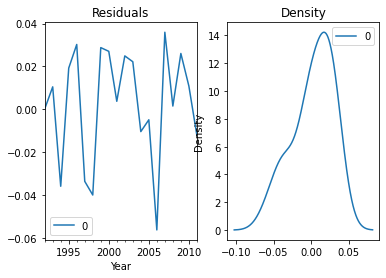

In [390]:
# Plot residual errors
residuals = pd.DataFrame(model_arima.resid)
fig, ax = plt.subplots(1,2)
residuals.plot(title="Residuals", ax=ax[0])
residuals.plot(kind='kde', title='Density', ax=ax[1])
plt.show()

In [391]:
def forecast_accuracy(forecast, actual):
    mape = np.mean(np.abs(forecast - actual)/np.abs(actual))  # MAPE
    me = np.mean(forecast - actual)             # ME
    mae = np.mean(np.abs(forecast - actual))    # MAE
    mpe = np.mean((forecast - actual)/actual)   # MPE
    rmse = np.mean((forecast - actual)**2)**.5  # RMSE
    return({'mape':mape, 'me':me, 'mae': mae, 
            'mpe': mpe, 'rmse':rmse})


In [392]:
stationary_arima_acc = forecast_accuracy(pred_arima.values, test.values)
stationary_arima_acc

{'mape': 0.9836649224066684,
 'me': -0.009362517709949697,
 'mae': 0.05025831885652338,
 'mpe': -0.9836649224066684,
 'rmse': 0.06143628270535255}

## Auto Regressor (AR) model

In [393]:
model_ar = AutoReg(train,lags = 6).fit()
print(model_ar.summary())

                            AutoReg Model Results                             
Dep. Variable:                    CO2   No. Observations:                   20
Model:                     AutoReg(6)   Log Likelihood                  32.548
Method:               Conditional MLE   S.D. of innovations              0.024
Date:                Sat, 09 Apr 2022   AIC                            -49.097
Time:                        19:06:02   BIC                            -43.984
Sample:                    01-01-1998   HQIC                           -49.570
                         - 01-01-2011                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const         -0.0060      0.007     -0.918      0.359      -0.019       0.007
CO2.L1        -0.8878      0.237     -3.750      0.000      -1.352      -0.424
CO2.L2        -1.1076      0.304     -3.642      0.0

In [394]:
pred_ar = model_ar.predict(start=start,end=end,dynamic = False)
print(pred_ar)

2012-01-01    0.007928
2013-01-01   -0.014471
2014-01-01    0.037865
2015-01-01   -0.010169
2016-01-01   -0.019014
2017-01-01   -0.001305
2018-01-01   -0.000546
Freq: AS-JAN, dtype: float64


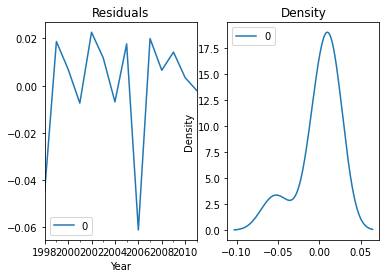

In [395]:
# Plot residual errors
residuals = pd.DataFrame(model_ar.resid)
fig, ax = plt.subplots(1,2)
residuals.plot(title="Residuals", ax=ax[0])
residuals.plot(kind='kde', title='Density', ax=ax[1])
plt.show()

In [396]:
stationary_ar_acc = forecast_accuracy(pred_ar.values, test.values)
stationary_ar_acc

{'mape': 1.1000522297882338,
 'me': -0.010763100041831874,
 'mae': 0.052162870526770475,
 'mpe': -0.9995333707272988,
 'rmse': 0.0638743558866742}

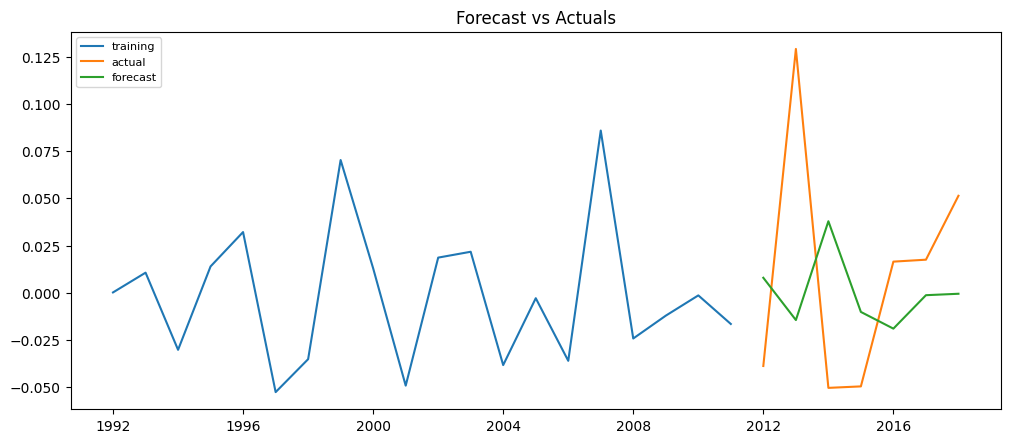

In [325]:
# Plot
plt.figure(figsize=(12,5), dpi=100)
plt.plot(train, label='training')
plt.plot(test, label='actual')
plt.plot(pred_ar, label='forecast')
plt.title('Forecast vs Actuals')
plt.legend(loc='upper left', fontsize=8)
plt.show()

## Moving Average (MA) model

In [397]:
# only use q or MA parameter
#MA(3)
model_ma = ARIMA(train['CO2'],order = (0,1,3))
model_ma = model_ma.fit()
model_ma.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                    CO2   No. Observations:                   20
Model:                 ARIMA(0, 1, 3)   Log Likelihood                  38.985
Date:                Sat, 09 Apr 2022   AIC                            -69.971
Time:                        19:08:03   BIC                            -66.193
Sample:                    01-01-1992   HQIC                           -69.331
                         - 01-01-2011                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ma.L1         -2.0314     12.376     -0.164      0.870     -26.289      22.226
ma.L2          1.1558     13.488      0.086      0.932     -25.281      27.592
ma.L3         -0.0829      0.926     -0.090      0.929      -1.898       1.732
sigma2         0.0006      0.008      0.078      0.938      -0.015       0.017
===================================================================================
Ljung-Box (L1) (Q):                   0.04   Jarque-Bera (JB):                 0.56
Prob(Q):                              0.85   Prob(JB):                         0.76
Heteroskedasticity (H):               1.18   Skew:                            -0.19
Prob(H) (two-sided):                  0.85   Kurtosis:                         2.25
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [398]:
pred_ma = model_ma.predict(start=start,end=end)
print(pred_ma)

2012-01-01    0.013576
2013-01-01   -0.001555
2014-01-01   -0.000493
2015-01-01   -0.000493
2016-01-01   -0.000493
2017-01-01   -0.000493
2018-01-01   -0.000493
Freq: AS-JAN, Name: predicted_mean, dtype: float64


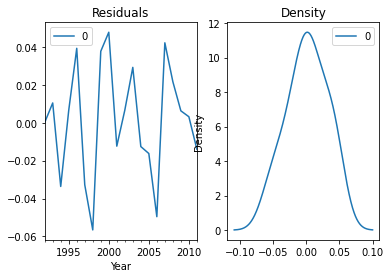

In [399]:
# Plot residual errors
residuals = pd.DataFrame(model_ma.resid)
fig, ax = plt.subplots(1,2)
residuals.plot(title="Residuals", ax=ax[0])
residuals.plot(kind='kde', title='Density', ax=ax[1])
plt.show()

In [400]:
stationary_ma_acc = forecast_accuracy(pred_ma.values, test.values)
stationary_ma_acc

{'mape': 0.9845339704142172,
 'me': -0.009439221698918043,
 'mae': 0.05026927656923315,
 'mpe': -0.9845339704142172,
 'rmse': 0.06138205796859194}

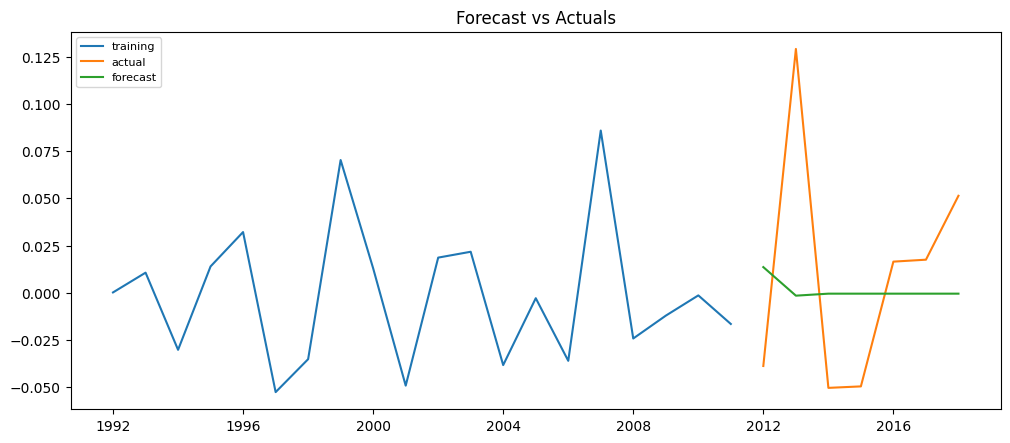

In [401]:
# Plot
plt.figure(figsize=(12,5), dpi=100)
plt.plot(train, label='training')
plt.plot(test, label='actual')
plt.plot(pred_ma, label='forecast')
plt.title('Forecast vs Actuals')
plt.legend(loc='upper left', fontsize=8)
plt.show()

## Auto ARIMA model

In [402]:
model = pm.auto_arima(train['CO2'], start_p=0, start_q=0,
                      test='adf',       # use adftest to find optimal 'd'
                      max_p=3, max_q=3, # maximum p and q
                      m=1,              # frequency of series
                      d=None,           # let model determine 'd'
                      seasonal=False,   # No Seasonality
                      start_P=0, 
                      D=0, 
                      trace=True,
                      error_action='ignore',  
                      suppress_warnings=True, 
                      stepwise=True)

print(model.summary())

Performing stepwise search to minimize aic
 ARIMA(0,0,0)(0,0,0)[0]             : AIC=-74.325, Time=0.03 sec
 ARIMA(1,0,0)(0,0,0)[0]             : AIC=-74.436, Time=0.04 sec
 ARIMA(0,0,1)(0,0,0)[0]             : AIC=inf, Time=0.17 sec
 ARIMA(2,0,0)(0,0,0)[0]             : AIC=-80.107, Time=0.15 sec
 ARIMA(3,0,0)(0,0,0)[0]             : AIC=-80.829, Time=0.27 sec
 ARIMA(3,0,1)(0,0,0)[0]             : AIC=-82.288, Time=0.53 sec
 ARIMA(2,0,1)(0,0,0)[0]             : AIC=-84.181, Time=0.32 sec
 ARIMA(1,0,1)(0,0,0)[0]             : AIC=inf, Time=0.34 sec
 ARIMA(2,0,2)(0,0,0)[0]             : AIC=-84.010, Time=0.63 sec
 ARIMA(1,0,2)(0,0,0)[0]             : AIC=inf, Time=0.40 sec
 ARIMA(3,0,2)(0,0,0)[0]             : AIC=-80.246, Time=0.58 sec
 ARIMA(2,0,1)(0,0,0)[0] intercept   : AIC=-84.766, Time=0.44 sec
 ARIMA(1,0,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.40 sec
 ARIMA(2,0,0)(0,0,0)[0] intercept   : AIC=-78.320, Time=0.26 sec
 ARIMA(3,0,1)(0,0,0)[0] intercept   : AIC=-82.972, Time=0.56 se

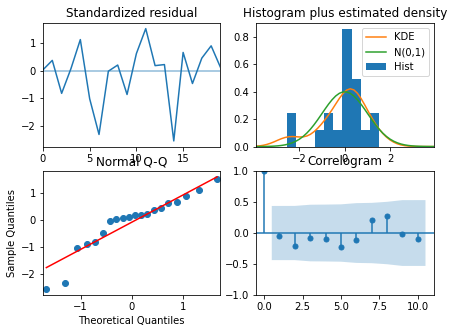

In [403]:
model.plot_diagnostics(figsize=(7,5))
plt.show()

In [428]:
pred = pd.DataFrame(model.predict(n_periods=7),index=test.index)
pred.columns=['predicted_emission']
print(pred)

            predicted_emission
Year                          
2012-01-01            0.003989
2013-01-01            0.009331
2014-01-01            0.000785
2015-01-01           -0.004569
2016-01-01           -0.002930
2017-01-01           -0.000086
2018-01-01            0.000262


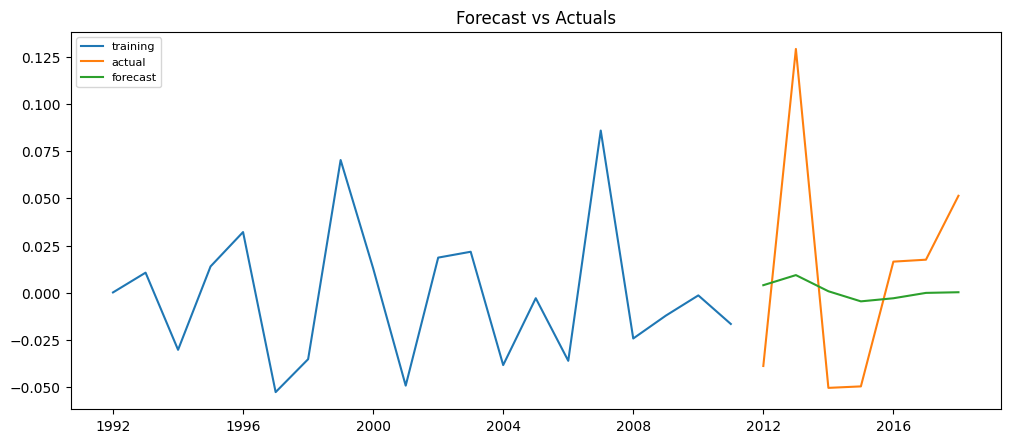

In [429]:
# Plot
plt.figure(figsize=(12,5), dpi=100)
plt.plot(train, label='training')
plt.plot(test, label='actual')
plt.plot(pred, label='forecast')
plt.title('Forecast vs Actuals')
plt.legend(loc='upper left', fontsize=8)
plt.show()

In [430]:
pred = model.predict(start=start,end=end)
print(pred)

[ 3.98917625e-03  9.33146420e-03  7.85309682e-04 -4.56890658e-03
 -2.93018999e-03 -8.57022774e-05  2.61875619e-04 -8.05802968e-04
 -1.34043003e-03 -1.08681751e-03]


In [431]:
stationary_aa_acc = forecast_accuracy(pred, test.values)
stationary_aa_acc

{'mape': 0.9959779146361413,
 'me': -0.010449288074685486,
 'mae': 0.05041357176577136,
 'mpe': -0.9959779146361413,
 'rmse': 0.061452502613665694}

In [432]:
data = {"MODEL":pd.Series(["ARIMA","Auto Regressor","Moving Average","Auto ARIMA"]),"RMSE_Values":pd.Series([stationary_arima_acc["rmse"],stationary_ar_acc["rmse"],
stationary_ma_acc["rmse"],stationary_aa_acc["rmse"]]),"MAPE_values":pd.Series([stationary_arima_acc["mape"],stationary_ar_acc["mape"],stationary_ma_acc["mape"],stationary_aa_acc["mape"]]),
"ME_values":pd.Series([stationary_arima_acc["me"],stationary_ar_acc["me"],stationary_ma_acc["me"],stationary_aa_acc["me"]]),
"MAE_values":pd.Series([stationary_arima_acc["mae"],stationary_ar_acc["mae"],stationary_ma_acc["mae"],stationary_aa_acc["mae"]]),
        "MPE_values":pd.Series([stationary_arima_acc["mpe"],stationary_ar_acc["mpe"],stationary_ma_acc["mpe"],stationary_aa_acc["mpe"]])}

table_rmse=pd.DataFrame(data)
table_rmse
#table_rmse.sort_values(['RMSE_Values'])

,MODEL,RMSE_Values,MAPE_values,ME_values,MAE_values,MPE_values
0,ARIMA,0.061436,0.983665,-0.009363,0.050258,-0.983665
1,Auto Regressor,0.063874,1.100052,-0.010763,0.052163,-0.999533
2,Moving Average,0.061382,0.984534,-0.009439,0.050269,-0.984534
3,Auto ARIMA,0.061453,0.995978,-0.010449,0.050414,-0.995978


# B) MODEL BUILDING ON NON-STATIONARY DATA / ORIGINAL DATA

In [433]:
df.head()

,CO2
Year,
1990-01-01,0.54548
1991-01-01,0.55520
1992-01-01,0.56508
1993-01-01,0.58559
1994-01-01,0.57586


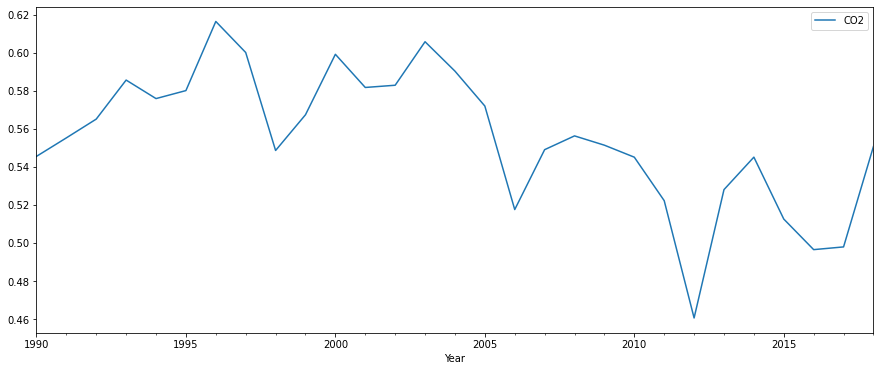

In [434]:
df.plot(figsize=(15, 6))
plt.show()

## Data Partitioning

In [435]:
train = df[:20]
test = df[20:]
print(train.shape,test.shape)

(20, 1) (9, 1)


In [436]:
train.head()

,CO2
Year,
1990-01-01,0.54548
1991-01-01,0.55520
1992-01-01,0.56508
1993-01-01,0.58559
1994-01-01,0.57586


In [437]:
test.head()

,CO2
Year,
2010-01-01,0.54506
2011-01-01,0.52221
2012-01-01,0.46055
2013-01-01,0.52801
2014-01-01,0.54508


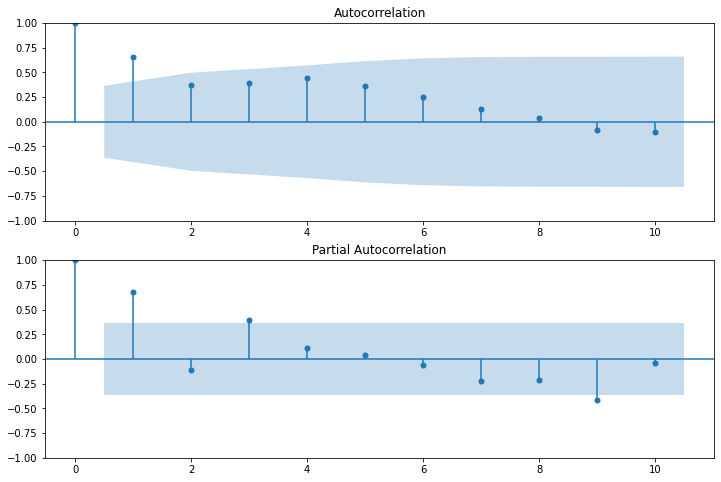

In [438]:
fig = plt.figure(figsize=(12,8))
ax1 = fig.add_subplot(211)
fig = sm.graphics.tsa.plot_acf(df, lags=10, ax=ax1)
ax2 = fig.add_subplot(212)
fig = sm.graphics.tsa.plot_pacf(df, lags=10, ax=ax2)

### Hyper-parameter Tuning : Finding out optimal (p,d,q)


In [439]:
# evaluate an ARIMA model for a given order (p,d,q)
def evaluate_arima_model(train, test, arima_order):
    history = [x for x in train]
    # make predictions
    predictions = list()
    for t in range(len(test)):
        model = ARIMA(history, order=arima_order)
        model_fit = model.fit()
        yhat = model_fit.forecast()[0]
        predictions.append(yhat)
        history.append(test[t])
    # calculate out of sample error
    rmse = sqrt(mean_squared_error(test, predictions))
    return rmse

In [440]:
# evaluate combinations of p, d and q values for an ARIMA model
def evaluate_models(train, test, p_values, d_values, q_values):
    #dataset = dataset.astype('float32')
    best_score, best_cfg = float("inf"), None
    for p in p_values:
        for d in d_values:
            for q in q_values:
                order = (p,d,q)
                try:
                    rmse = evaluate_arima_model(train, test, order)
                    if rmse < best_score:
                        best_score, best_cfg = rmse, order
                    print('ARIMA%s RMSE=%.3f' % (order,rmse))
                except:
                    continue
    print('Best ARIMA%s RMSE=%.3f' % (best_cfg, best_score))

In [441]:
# evaluate parameters
p_values = [0,1,2,3,4,5]
d_values = range(0, 5)
q_values = range(0, 5)
warnings.filterwarnings("ignore")
evaluate_models(train.values, test.values, p_values, d_values, q_values)

ARIMA(0, 0, 0) RMSE=0.054
ARIMA(0, 0, 1) RMSE=0.041
ARIMA(0, 0, 2) RMSE=0.041
ARIMA(0, 0, 3) RMSE=0.045
ARIMA(0, 0, 4) RMSE=0.042
ARIMA(0, 1, 0) RMSE=0.038
ARIMA(0, 1, 1) RMSE=0.042
ARIMA(0, 1, 2) RMSE=0.038
ARIMA(0, 1, 3) RMSE=0.038
ARIMA(0, 1, 4) RMSE=0.034
ARIMA(0, 2, 0) RMSE=0.054
ARIMA(0, 2, 1) RMSE=0.041
ARIMA(0, 2, 2) RMSE=0.047
ARIMA(0, 2, 3) RMSE=0.036
ARIMA(0, 2, 4) RMSE=0.038
ARIMA(0, 3, 0) RMSE=0.086
ARIMA(0, 3, 1) RMSE=0.056
ARIMA(0, 3, 2) RMSE=0.041
ARIMA(0, 3, 3) RMSE=0.051
ARIMA(0, 3, 4) RMSE=0.040
ARIMA(0, 4, 0) RMSE=0.149
ARIMA(0, 4, 1) RMSE=0.089
ARIMA(0, 4, 2) RMSE=0.058
ARIMA(0, 4, 3) RMSE=0.042
ARIMA(1, 0, 0) RMSE=0.040
ARIMA(1, 0, 1) RMSE=0.041
ARIMA(1, 0, 2) RMSE=0.040
ARIMA(1, 0, 3) RMSE=0.041
ARIMA(1, 0, 4) RMSE=0.042
ARIMA(1, 1, 0) RMSE=0.040
ARIMA(1, 1, 1) RMSE=0.043
ARIMA(1, 1, 2) RMSE=0.038
ARIMA(1, 1, 3) RMSE=0.037
ARIMA(1, 1, 4) RMSE=0.035
ARIMA(1, 2, 0) RMSE=0.053
ARIMA(1, 2, 1) RMSE=0.043
ARIMA(1, 2, 2) RMSE=0.043
ARIMA(1, 2, 3) RMSE=0.044
ARIMA(1, 2, 

## ARIMA

In [442]:
model_arima = ARIMA(train['CO2'],order = (2,1,2))
model_arima = model_arima.fit()
model_arima.summary()


<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                    CO2   No. Observations:                   20
Model:                 ARIMA(2, 1, 2)   Log Likelihood                  46.958
Date:                Sat, 09 Apr 2022   AIC                            -83.917
Time:                        22:26:51   BIC                            -79.195
Sample:                    01-01-1990   HQIC                           -83.118
                         - 01-01-2009                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.0665      0.433     -0.154      0.878      -0.916       0.783
ar.L2         -0.9808      0.233     -4.208      0.000      -1.438      -0.524
ma.L1         -0.0925      1.114     -0.083      0.934      -2.275       2.090
ma.L2          0.9307      1.580      0.589      0.556      -2.167       4.028
sigma2         0.0004      0.001      0.654      0.513      -0.001       0.001
===================================================================================
Ljung-Box (L1) (Q):                   0.01   Jarque-Bera (JB):                 3.79
Prob(Q):                              0.92   Prob(JB):                         0.15
Heteroskedasticity (H):               2.37   Skew:                            -1.07
Prob(H) (two-sided):                  0.32   Kurtosis:                         3.46
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [443]:
start = len(train)
end = len(train)+len(test)-1
pred_arima = model_arima.predict(start=start,end=end)
print(pred_arima)

2010-01-01    0.541634
2011-01-01    0.562065
2012-01-01    0.570245
2013-01-01    0.549662
2014-01-01    0.543010
2015-01-01    0.563639
2016-01-01    0.568791
2017-01-01    0.548216
2018-01-01    0.544532
Freq: AS-JAN, Name: predicted_mean, dtype: float64


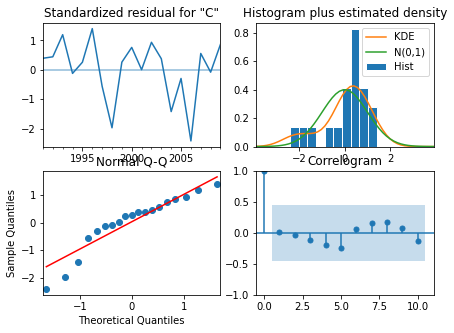

In [444]:
model_arima.plot_diagnostics(figsize=(7,5))
plt.show()

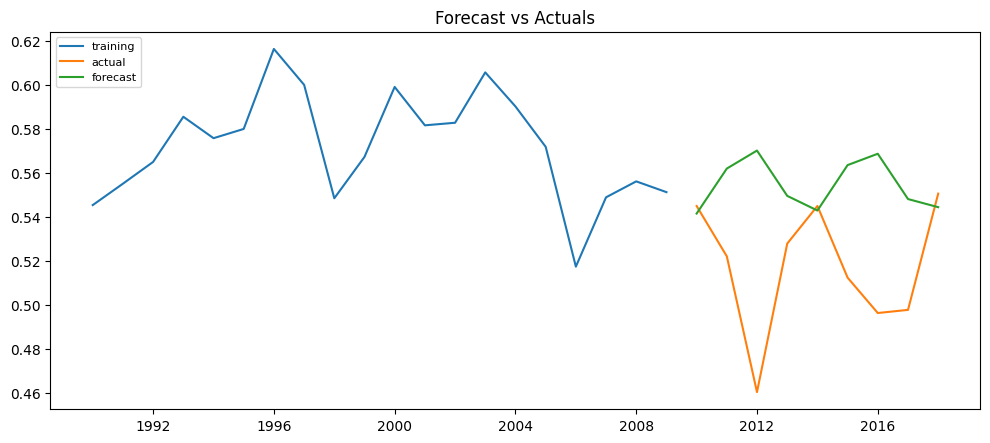

In [445]:
# Plot
plt.figure(figsize=(12,5), dpi=100)
plt.plot(train, label='training')
plt.plot(test, label='actual')
plt.plot(pred_arima, label='forecast')
#plt.fill_between(lower_series.index, lower_series, upper_series, 
                 #color='k', alpha=.15)
plt.title('Forecast vs Actuals')
plt.legend(loc='upper left', fontsize=8)
plt.show()

In [446]:
ns_arima_acc = forecast_accuracy(pred_arima,test.CO2)
ns_arima_acc

{'mape': 0.08035352730832702,
 'me': 0.03703252302008609,
 'mae': 0.03962026176847136,
 'mpe': 0.07563151896212256,
 'rmse': 0.05219309413936985}

## Auto ARIMA

In [447]:
model_auto = pm.auto_arima(train['CO2'], start_p=0, start_q=0,
                      test='adf',       # use adftest to find optimal 'd'
                      max_p=4, max_q=4, # maximum p and q
                      m=1,              # frequency of series
                      d=None,           # let model determine 'd'
                      seasonal=False,   # No Seasonality
                      start_P=0, 
                      D=0, 
                      trace=True,
                      error_action='ignore',  
                      suppress_warnings=True, 
                      stepwise=True)

print(model_auto.summary())

Performing stepwise search to minimize aic
 ARIMA(0,2,0)(0,0,0)[0] intercept   : AIC=-62.998, Time=0.07 sec
 ARIMA(1,2,0)(0,0,0)[0] intercept   : AIC=-62.944, Time=0.14 sec
 ARIMA(0,2,1)(0,0,0)[0] intercept   : AIC=-72.600, Time=0.46 sec
 ARIMA(0,2,0)(0,0,0)[0]             : AIC=-64.990, Time=0.05 sec
 ARIMA(1,2,1)(0,0,0)[0] intercept   : AIC=-70.657, Time=0.41 sec
 ARIMA(0,2,2)(0,0,0)[0] intercept   : AIC=-73.262, Time=0.71 sec
 ARIMA(1,2,2)(0,0,0)[0] intercept   : AIC=inf, Time=0.86 sec
 ARIMA(0,2,3)(0,0,0)[0] intercept   : AIC=inf, Time=0.86 sec
 ARIMA(1,2,3)(0,0,0)[0] intercept   : AIC=inf, Time=0.72 sec
 ARIMA(0,2,2)(0,0,0)[0]             : AIC=-72.118, Time=0.44 sec

Best model:  ARIMA(0,2,2)(0,0,0)[0] intercept
Total fit time: 4.777 seconds
                               SARIMAX Results                                
Dep. Variable:                      y   No. Observations:                   20
Model:               SARIMAX(0, 2, 2)   Log Likelihood                  40.631
Date:

In [450]:
pred_auto_arima = pd.DataFrame(model_auto.predict(n_periods=9),index=test.index)
pred_auto_arima.columns=['predicted_emission']
print(pred_auto_arima)

            predicted_emission
Year                          
2010-01-01            0.527114
2011-01-01            0.515795
2012-01-01            0.503515
2013-01-01            0.490276
2014-01-01            0.476076
2015-01-01            0.460916
2016-01-01            0.444796
2017-01-01            0.427716
2018-01-01            0.409676


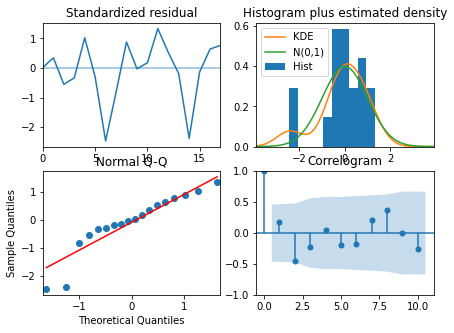

In [451]:
model_auto.plot_diagnostics(figsize=(7,5))
plt.show()

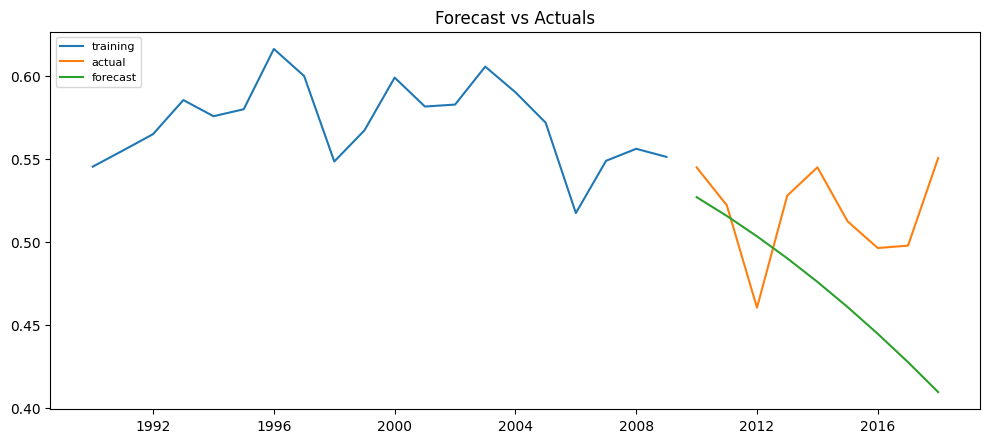

In [452]:
# Plot
plt.figure(figsize=(12,5), dpi=100)
plt.plot(train, label='training')
plt.plot(test, label='actual')
plt.plot(pred_auto_arima, label='forecast')
plt.title('Forecast vs Actuals')
plt.legend(loc='upper left', fontsize=8)
plt.show()

## Auto Regressor 

In [453]:
model_ar = AutoReg(train,lags = 1).fit()
print(model_ar.summary())

                            AutoReg Model Results                             
Dep. Variable:                    CO2   No. Observations:                   20
Model:                     AutoReg(1)   Log Likelihood                  46.441
Method:               Conditional MLE   S.D. of innovations              0.021
Date:                Sat, 09 Apr 2022   AIC                            -86.881
Time:                        22:30:36   BIC                            -84.048
Sample:                    01-01-1991   HQIC                           -86.402
                         - 01-01-2009                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.3215      0.116      2.767      0.006       0.094       0.549
CO2.L1         0.4398      0.202      2.172      0.030       0.043       0.837
                                    Roots           

In [454]:
pred_ar = model_ar.predict(start=start,end=end,dynamic = False)
print(pred_ar)

2010-01-01    0.564002
2011-01-01    0.569562
2012-01-01    0.572008
2013-01-01    0.573084
2014-01-01    0.573557
2015-01-01    0.573765
2016-01-01    0.573856
2017-01-01    0.573897
2018-01-01    0.573914
Freq: AS-JAN, dtype: float64


In [455]:
ns_ar_acc = forecast_accuracy(pred_ar.values, test.values)
ns_ar_acc

{'mape': 0.10827350807443806,
 'me': 0.05434945713154418,
 'mae': 0.05434945713154418,
 'mpe': 0.10827350807443806,
 'rmse': 0.06102828899355398}

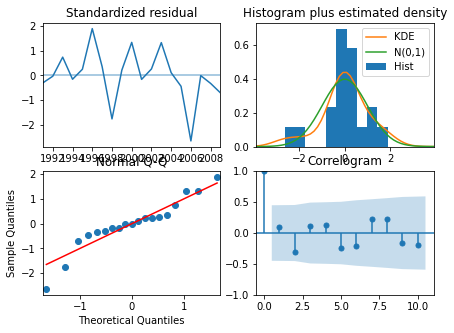

In [456]:
model_ar.plot_diagnostics(figsize=(7,5))
plt.show()

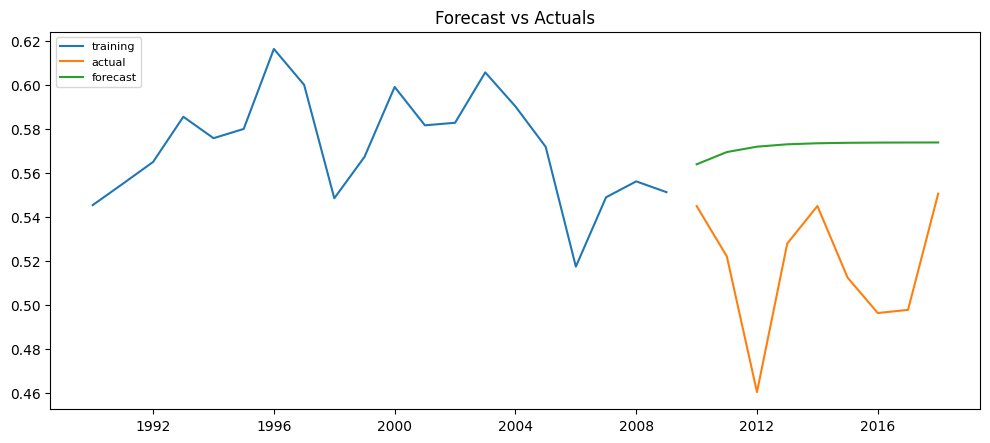

In [457]:
# Plot
plt.figure(figsize=(12,5), dpi=100)
plt.plot(train, label='training')
plt.plot(test, label='actual')
plt.plot(pred_ar, label='forecast')
plt.title('Forecast vs Actuals')
plt.legend(loc='upper left', fontsize=8)
plt.show()

## Single Exponential Smoothing

In [458]:
fit1 = SimpleExpSmoothing(train).fit(smoothing_level = 0.2,optimized = False)
fit2 =SimpleExpSmoothing(train).fit(smoothing_level = 0.8,optimized = False)

Text(0.5, 1.0, 'Fitted values Vs Original Values')

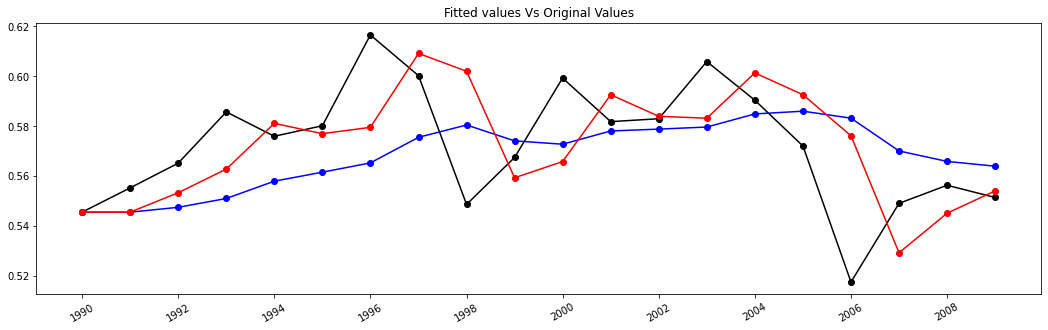

In [459]:
plt.figure(figsize=(18,5))
plt.plot(train,marker = 'o',color = 'black')
plt.xticks(rotation=30)
plt.plot(fit1.fittedvalues,marker = 'o',color = 'blue')
plt.plot(fit2.fittedvalues,marker = 'o',color = 'red')
plt.title('Fitted values Vs Original Values')

In [460]:
pred_ses = fit1.predict(start = len(train),end = len(train)+len(test)-1)

In [461]:
ns_ses_acc = forecast_accuracy(pred_ses,test.CO2)
ns_ses_acc

{'mape': 0.08776519211821329,
 'me': 0.043765474060070836,
 'mae': 0.043765474060070836,
 'mpe': 0.08776519211821329,
 'rmse': 0.051733001466089196}

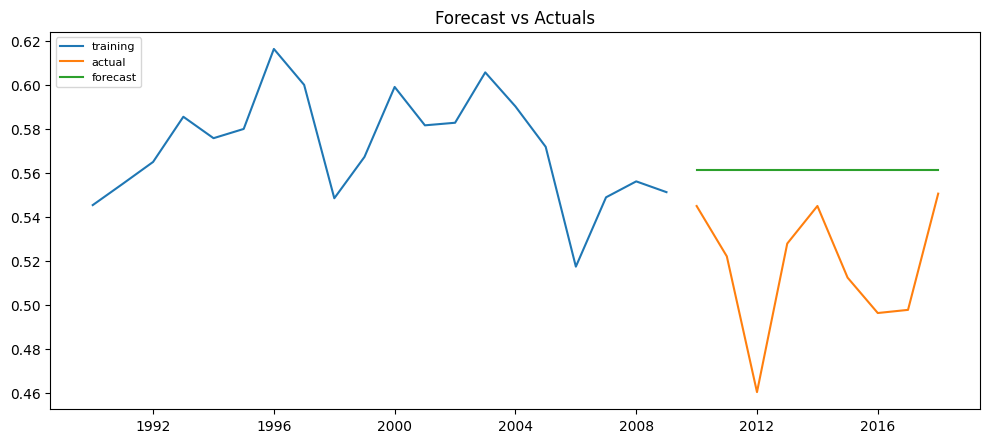

In [462]:
# Plot
plt.figure(figsize=(12,5), dpi=100)
plt.plot(train, label='training')
plt.plot(test, label='actual')
plt.plot(pred_ses, label='forecast')
plt.title('Forecast vs Actuals')
plt.legend(loc='upper left', fontsize=8)
plt.show()

## Double Exponential Smoothing or Holt's method

In [463]:
#fit1 = Holt(train1).fit()
fit3 = Holt(train,exponential=True,damped_trend=False).fit()

Text(0.5, 1.0, 'Fitted values Vs Original Values')

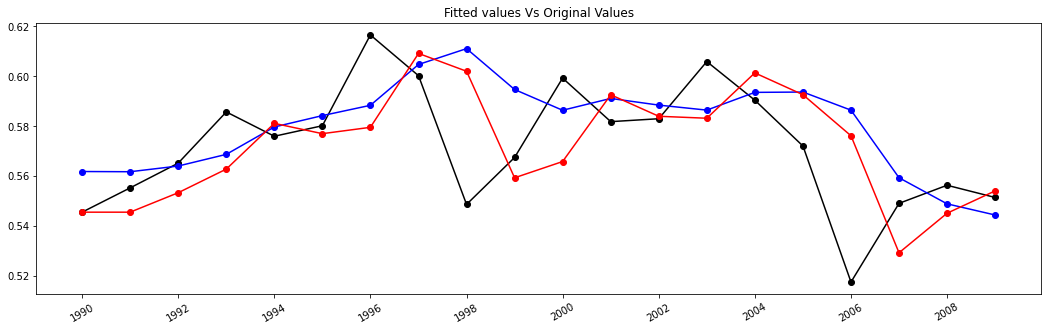

In [464]:
plt.figure(figsize=(18,5))
plt.plot(train,marker = 'o',color = 'black')
plt.xticks(rotation=30)
plt.plot(fit3.fittedvalues,marker = 'o',color = 'blue')
plt.plot(fit2.fittedvalues,marker = 'o',color = 'red')
plt.title('Fitted values Vs Original Values')

In [465]:
pred_holt = fit3.predict(start = len(train),end = len(train)+len(test)-1)

In [466]:
ns_des_acc = forecast_accuracy(pred_holt,test.CO2)
ns_des_acc

{'mape': 0.040928921896488474,
 'me': -0.00038240318649219237,
 'mae': 0.020774334786601036,
 'mpe': 0.0022467887973355075,
 'rmse': 0.03135590256392156}

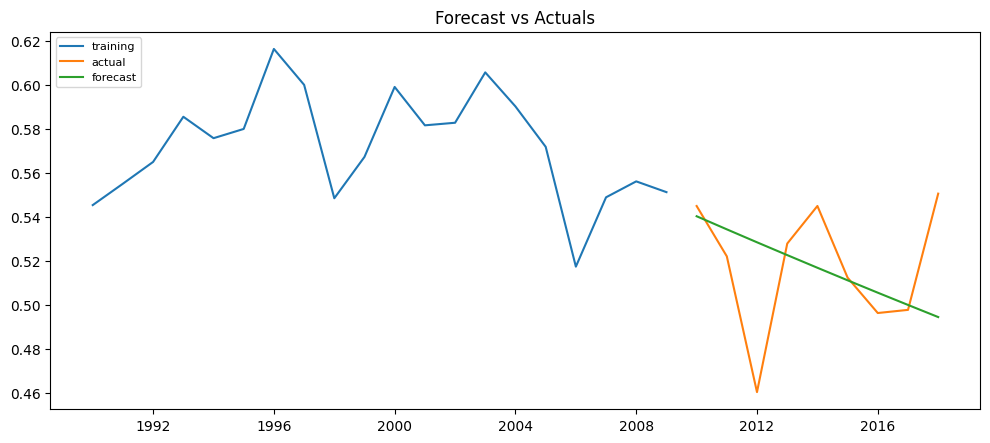

In [467]:
# Plot
plt.figure(figsize=(12,5), dpi=100)
plt.plot(train, label='training')
plt.plot(test, label='actual')
plt.plot(pred_holt, label='forecast')
plt.title('Forecast vs Actuals')
plt.legend(loc='upper left', fontsize=8)
plt.show()

## Triple Exponential Smoothing or Holt - Winter's Method

**seasonality = additive** , **Trend = additive**

In [468]:
# Holts winter exponential smoothing with additive seasonality and additive trend
hwe_model_add_add = ExponentialSmoothing(train["CO2"],seasonal="add",trend="add",seasonal_periods=2,damped=True).fit()
pred_hwe_add_add = hwe_model_add_add.predict(start = start,end = end)

In [469]:
ns_tes_add_add_acc = forecast_accuracy(pred_hwe_add_add,test.CO2)
ns_tes_add_add_acc

{'mape': 0.06783902842064513,
 'me': 0.032955619448109805,
 'mae': 0.03351149675161882,
 'mpe': 0.06682959044666929,
 'rmse': 0.04318868737237137}

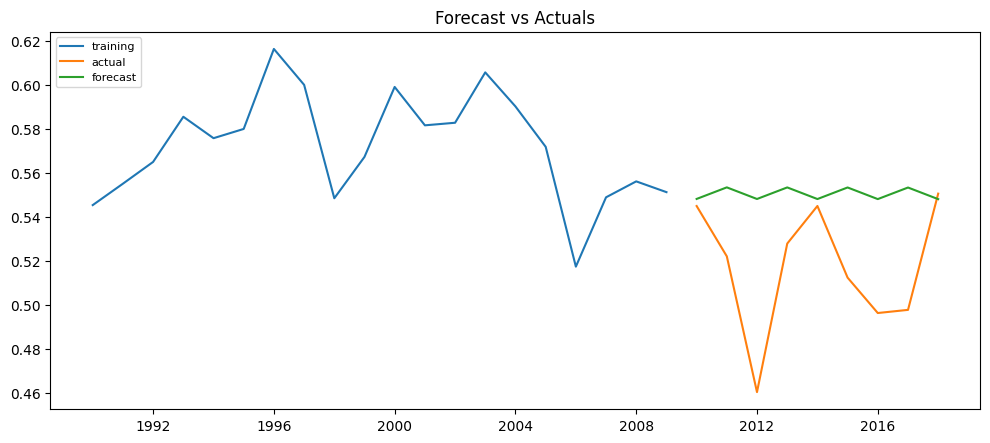

In [470]:
# Plot
plt.figure(figsize=(12,5), dpi=100)
plt.plot(train, label='training')
plt.plot(test, label='actual')
plt.plot(pred_hwe_add_add, label='forecast')
plt.title('Forecast vs Actuals')
plt.legend(loc='upper left', fontsize=8)
plt.show()

**seasonality = multiplicative** , **Trend = additive**

In [471]:
# Holts winter exponential smoothing with multiplicative seasonality and additive trend
hwe_model_mul_add = ExponentialSmoothing(train["CO2"],seasonal="mul",trend="add",seasonal_periods=2).fit()
pred_hwe_mul_add = hwe_model_mul_add.predict(start = start,end = end)

In [472]:
ns_tes_mul_add_acc = forecast_accuracy(pred_hwe_mul_add,test.CO2)
ns_tes_mul_add_acc

{'mape': 0.06630046476629288,
 'me': 0.03178176584441874,
 'mae': 0.03274255415117974,
 'mpe': 0.06455573405742203,
 'rmse': 0.042297346769456345}

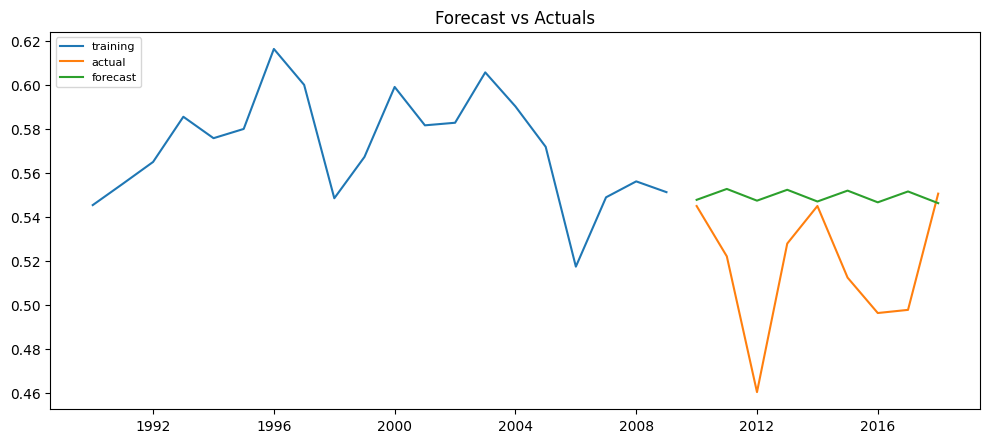

In [473]:
# Plot
plt.figure(figsize=(12,5), dpi=100)
plt.plot(train, label='training')
plt.plot(test, label='actual')
plt.plot(pred_hwe_mul_add, label='forecast')
plt.title('Forecast vs Actuals')
plt.legend(loc='upper left', fontsize=8)
plt.show()

**seasonality = multiplicative , Trend = multiplicative**

In [474]:
# Holts winter exponential smoothing with multiplicative seasonality and additive trend
hwe_model_mul_mul = ExponentialSmoothing(train["CO2"],seasonal="mul",trend="mul",seasonal_periods=2).fit()
pred_hwe_mul_mul = hwe_model_mul_add.predict(start = start,end = end)

In [475]:
ns_tes_mul_mul_acc = forecast_accuracy(pred_hwe_mul_mul,test.CO2)
ns_tes_mul_mul_acc

{'mape': 0.06630046476629288,
 'me': 0.03178176584441874,
 'mae': 0.03274255415117974,
 'mpe': 0.06455573405742203,
 'rmse': 0.042297346769456345}

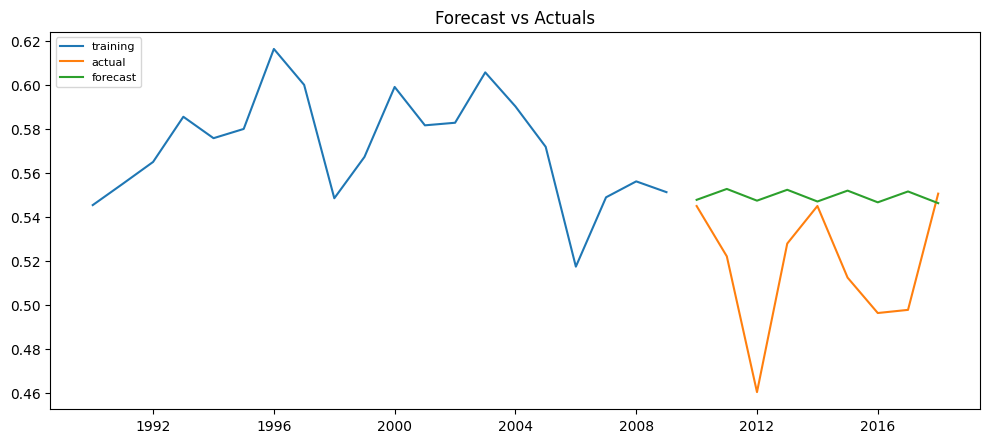

In [476]:
# Plot
plt.figure(figsize=(12,5), dpi=100)
plt.plot(train, label='training')
plt.plot(test, label='actual')
plt.plot(pred_hwe_mul_mul, label='forecast')
plt.title('Forecast vs Actuals')
plt.legend(loc='upper left', fontsize=8)
plt.show()

## LSTM using RNN

In [477]:
scaler = MinMaxScaler()

In [478]:
scaler.fit(train)
scaled_train = scaler.transform(train)
scaled_test = scaler.transform(test)

In [479]:
scaled_train[:10]

array([[0.28272304],
       [0.3810439 ],
       [0.48098321],
       [0.68844831],
       [0.5900263 ],
       [0.63251062],
       [1.        ],
       [0.83501922],
       [0.31408052],
       [0.50404613]])

In [480]:
#define generator
n_input = 5
n_features = 1
generator = TimeseriesGenerator(scaled_train,scaled_train,length=n_input,batch_size=1)

In [481]:
X,y = generator[0]
print(f'given the array: \n{X.flatten()}')
print(f'predict this y: \n {y}')

given the array: 
[0.28272304 0.3810439  0.48098321 0.68844831 0.5900263 ]
predict this y: 
 [[0.63251062]]


In [482]:
X.shape

(1, 5, 1)

In [483]:
#define model
model = Sequential()
model.add(LSTM(60, activation = 'relu',return_sequences = True, input_shape=(n_input,n_features)))
model.add(Dropout(0.2))

model.add(LSTM(60, activation = 'relu', return_sequences = True))
model.add(Dropout(0.2))

model.add(LSTM(60, activation = 'relu', return_sequences = True))
model.add(Dropout(0.2))

model.add(LSTM(60, activation = 'relu'))
model.add(Dropout(0.2))

model.add(Dense(units = 1))
model.compile(optimizer='adam',loss='mean_squared_error')

In [484]:
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_4 (LSTM)               (None, 5, 60)             14880     
                                                                 
 dropout_4 (Dropout)         (None, 5, 60)             0         
                                                                 
 lstm_5 (LSTM)               (None, 5, 60)             29040     
                                                                 
 dropout_5 (Dropout)         (None, 5, 60)             0         
                                                                 
 lstm_6 (LSTM)               (None, 5, 60)             29040     
                                                                 
 dropout_6 (Dropout)         (None, 5, 60)             0         
                                                                 
 lstm_7 (LSTM)               (None, 60)               

In [485]:
#fit model
model.fit(generator,epochs=50,batch_size=32,verbose=1)

Epoch 1/50
15/15 [==============================] - 11s 26ms/step - loss: 0.3620
Epoch 2/50
15/15 [==============================] - 0s 13ms/step - loss: 0.2014
Epoch 3/50
15/15 [==============================] - 0s 14ms/step - loss: 0.0968
Epoch 4/50
15/15 [==============================] - 0s 13ms/step - loss: 0.0816
Epoch 5/50
15/15 [==============================] - 0s 15ms/step - loss: 0.0828
Epoch 6/50
15/15 [==============================] - 0s 14ms/step - loss: 0.0806
Epoch 7/50
15/15 [==============================] - 0s 14ms/step - loss: 0.0755
Epoch 8/50
15/15 [==============================] - 0s 14ms/step - loss: 0.0816
Epoch 9/50
15/15 [==============================] - 0s 15ms/step - loss: 0.0910
Epoch 10/50
15/15 [==============================] - 0s 15ms/step - loss: 0.0719
Epoch 11/50
15/15 [==============================] - 0s 14ms/step - loss: 0.0849
Epoch 12/50
15/15 [==============================] - 0s 16ms/step - loss: 0.0972
Epoch 13/50
15/15 [=================

Text(0.5, 1.0, 'Loss per Epochs')

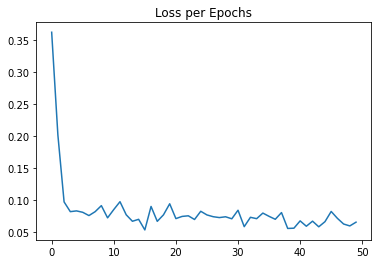

In [486]:
loss_per_epoch = model.history.history['loss']
plt.plot(range(len(loss_per_epoch)),loss_per_epoch)
plt.title('Loss per Epochs')

In [487]:
last_train_batch = scaled_train[-5:]

In [488]:
last_train_batch = last_train_batch.reshape(1,n_input,n_features)

In [489]:
model.predict(last_train_batch)

array([[0.53969216]], dtype=float32)

In [490]:
scaled_test[0]

array([0.27847461])

In [491]:
test_predictions =[]

first_eval_batch = scaled_train[-n_input:]
current_batch = first_eval_batch.reshape(1,n_input,n_features)

for i in range(len(test)):
    
    #get the prediction value for first batch
    current_pred = model.predict(current_batch)[0]
    
    #append the prediction into the array
    test_predictions.append(current_pred)
    
    #use the prediction to update the batch and remove the first value
    current_batch = np.append(current_batch[:,1:,:],[[current_pred]],axis =1)

In [492]:
test_predictions

[array([0.53969216], dtype=float32),
 array([0.65168834], dtype=float32),
 array([0.67159], dtype=float32),
 array([0.644637], dtype=float32),
 array([0.6204455], dtype=float32),
 array([0.5536622], dtype=float32),
 array([0.5292091], dtype=float32),
 array([0.52985984], dtype=float32),
 array([0.54249734], dtype=float32)]

In [493]:
test.head()

,CO2
Year,
2010-01-01,0.54506
2011-01-01,0.52221
2012-01-01,0.46055
2013-01-01,0.52801
2014-01-01,0.54508


In [494]:
true_predictions = scaler.inverse_transform(test_predictions)

In [495]:
test['Predictions'] = true_predictions

<AxesSubplot:xlabel='Year'>

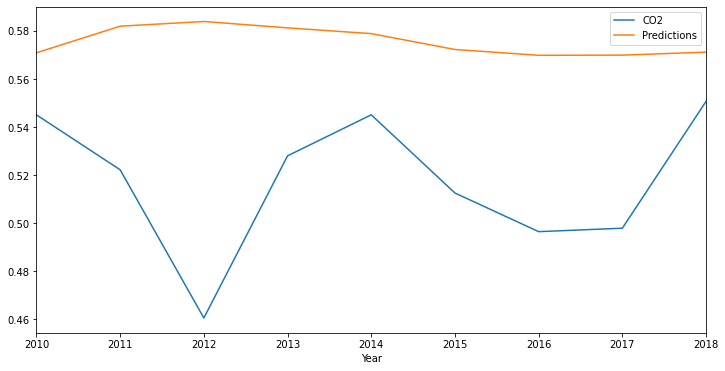

In [496]:
test.plot(figsize=(12,6))

In [497]:
ns_lstm_acc = forecast_accuracy(test['Predictions'],test.CO2)
ns_lstm_acc

{'mape': 0.11540610300887735,
 'me': 0.05795279975665943,
 'mae': 0.05795279975665943,
 'mpe': 0.11540610300887735,
 'rmse': 0.0649709457802766}

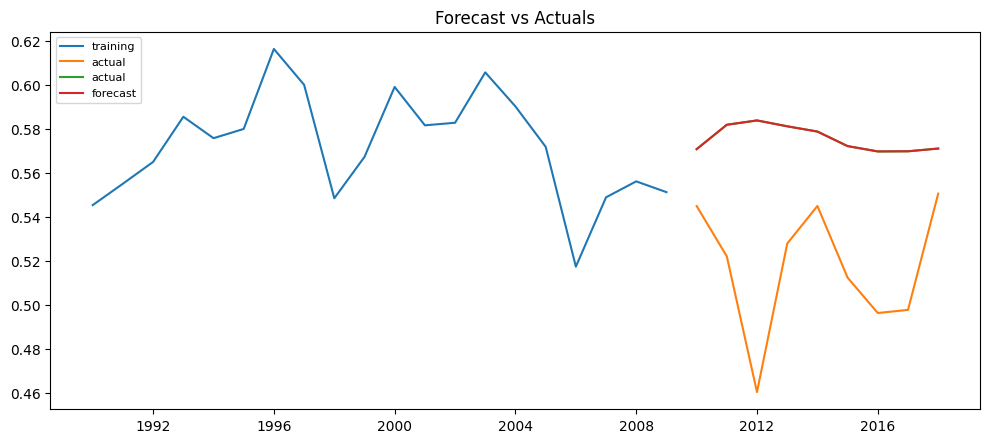

In [498]:
# Plot
plt.figure(figsize=(12,5), dpi=100)
plt.plot(train, label='training')
plt.plot(test, label='actual')
plt.plot(test['Predictions'], label='forecast')
#plt.fill_between(lower_series.index, lower_series, upper_series, 
                 #color='k', alpha=.15)
plt.title('Forecast vs Actuals')
plt.legend(loc='upper left', fontsize=8)
plt.show()

## Forecasting Accuracy

In [499]:
data = {"MODEL":pd.Series(["ARIMA(2,1,2)","Auto Regressor","single exponential smoothing","Double exponential smoothing","Triple exponential smoothing(additive seasonality & additive trend)","Triple exponential smoothing(multiplicative seasonality & additive trend)","Triple exponential smoothing(multiplicative seasonality & multiplicative trend)","LSTM(RNN)"]),
"RMSE_values":pd.Series([ns_arima_acc["rmse"],ns_ar_acc["rmse"],ns_ses_acc["rmse"],ns_des_acc["rmse"],ns_tes_add_add_acc["rmse"],ns_tes_mul_add_acc["rmse"],ns_tes_mul_mul_acc["rmse"],ns_lstm_acc["rmse"]]),
"MAPE_values":pd.Series([ns_arima_acc["mape"],ns_ar_acc["mape"],ns_ses_acc["mape"],ns_des_acc["mape"],ns_tes_add_add_acc["mape"],ns_tes_mul_add_acc["mape"],ns_tes_mul_mul_acc["mape"],ns_lstm_acc["mape"]]),
"ME_values":pd.Series([ns_arima_acc["me"],ns_ar_acc["me"],ns_ses_acc["me"],ns_des_acc["me"],ns_tes_add_add_acc["me"],ns_tes_mul_add_acc["me"],ns_tes_mul_mul_acc["me"],ns_lstm_acc["me"]]),
"MAE_values":pd.Series([ns_arima_acc["mae"],ns_ar_acc["mae"],ns_ses_acc["mae"],ns_des_acc["mae"],ns_tes_add_add_acc["mae"],ns_tes_mul_add_acc["mae"],ns_tes_mul_mul_acc["mae"],ns_lstm_acc["mae"]]),
"MPE_values":pd.Series([ns_arima_acc["mpe"],ns_ar_acc["mpe"],ns_ses_acc["mpe"],ns_des_acc["mpe"],ns_tes_add_add_acc["mpe"],ns_tes_mul_add_acc["mpe"],ns_tes_mul_mul_acc["mpe"],ns_lstm_acc["mpe"]])}

table_rmse=pd.DataFrame(data)
table_rmse.sort_values(['MAPE_values'])

,MODEL,RMSE_values,MAPE_values,ME_values,MAE_values,MPE_values
3,Double exponential smoothing,0.031356,0.040929,-0.000382,0.020774,0.002247
5,Triple exponential smoothing(multiplicative se...,0.042297,0.066300,0.031782,0.032743,0.064556
6,Triple exponential smoothing(multiplicative se...,0.042297,0.066300,0.031782,0.032743,0.064556
4,Triple exponential smoothing(additive seasonal...,0.043189,0.067839,0.032956,0.033511,0.066830
0,"ARIMA(2,1,2)",0.052193,0.080354,0.037033,0.039620,0.075632
2,single exponential smoothing,0.051733,0.087765,0.043765,0.043765,0.087765
1,Auto Regressor,0.061028,0.108274,0.054349,0.054349,0.108274
7,LSTM(RNN),0.064971,0.115406,0.057953,0.057953,0.115406


# Final Model

We have selected **Auto Regressor** as our final model beacuse of following reasons:
- least MAPE & MAE value
- Forecasted values vs Actual values graphs capturing more information when compared to other models

In [507]:
final_model_ar = AutoReg(df['CO2'],lags=6).fit()
print(final_model_ar.summary())

                            AutoReg Model Results                             
Dep. Variable:                    CO2   No. Observations:                   29
Model:                     AutoReg(6)   Log Likelihood                  51.246
Method:               Conditional MLE   S.D. of innovations              0.026
Date:                Sat, 09 Apr 2022   AIC                            -86.492
Time:                        23:06:07   BIC                            -77.408
Sample:                    01-01-1996   HQIC                           -84.207
                         - 01-01-2018                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0710      0.116      0.610      0.542      -0.157       0.299
CO2.L1         0.6256      0.215      2.910      0.004       0.204       1.047
CO2.L2        -0.3512      0.260     -1.351      0.1

In [500]:
final_model_ar = AutoReg(train,lags = 6).fit()
print(final_model_ar.summary())
final_arima = ARIMA(df['CO2'],order = (2,1,2))
final_arima = final_arima.fit()
final_arima.summary()

                            AutoReg Model Results                             
Dep. Variable:                    CO2   No. Observations:                   20
Model:                     AutoReg(6)   Log Likelihood                  35.474
Method:               Conditional MLE   S.D. of innovations              0.019
Date:                Sat, 09 Apr 2022   AIC                            -54.948
Time:                        22:58:16   BIC                            -49.835
Sample:                    01-01-1996   HQIC                           -55.421
                         - 01-01-2009                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          1.1376      0.485      2.347      0.019       0.187       2.088
CO2.L1         0.4546      0.267      1.701      0.089      -0.069       0.978
CO2.L2        -0.4555      0.292     -1.557      0.1

In [503]:
""" 
final_arima = ARIMA(df['CO2'],order = (2,1,2))
final_arima = final_arima.fit()
final_arima.summary() """

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                    CO2   No. Observations:                   29
Model:                 ARIMA(2, 1, 2)   Log Likelihood                  62.848
Date:                Sat, 09 Apr 2022   AIC                           -115.696
Time:                        23:00:47   BIC                           -109.035
Sample:                    01-01-1990   HQIC                          -113.660
                         - 01-01-2018                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.2481      0.730      0.340      0.734      -1.182       1.678
ar.L2         -0.5343      0.535     -0.998      0.318      -1.583       0.515
ma.L1         -0.5504      0.732     -0.752      0.452      -1.985       0.884
ma.L2          0.1508      0.640      0.236      0.814      -1.104       1.405
sigma2         0.0006      0.000      3.750      0.000       0.000       0.001
===================================================================================
Ljung-Box (L1) (Q):                   0.00   Jarque-Bera (JB):                 5.64
Prob(Q):                              0.99   Prob(JB):                         0.06
Heteroskedasticity (H):               2.20   Skew:                            -0.91
Prob(H) (two-sided):                  0.26   Kurtosis:                         4.22
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [504]:
#final_arima.fittedvalues.tail()

Year
2014-01-01    0.547942
2015-01-01    0.520010
2016-01-01    0.499027
2017-01-01    0.510151
2018-01-01    0.513199
dtype: float64

In [508]:
final_model_ar.fittedvalues.tail()

Year
2014-01-01    0.552585
2015-01-01    0.513923
2016-01-01    0.501401
2017-01-01    0.508658
2018-01-01    0.517853
dtype: float64

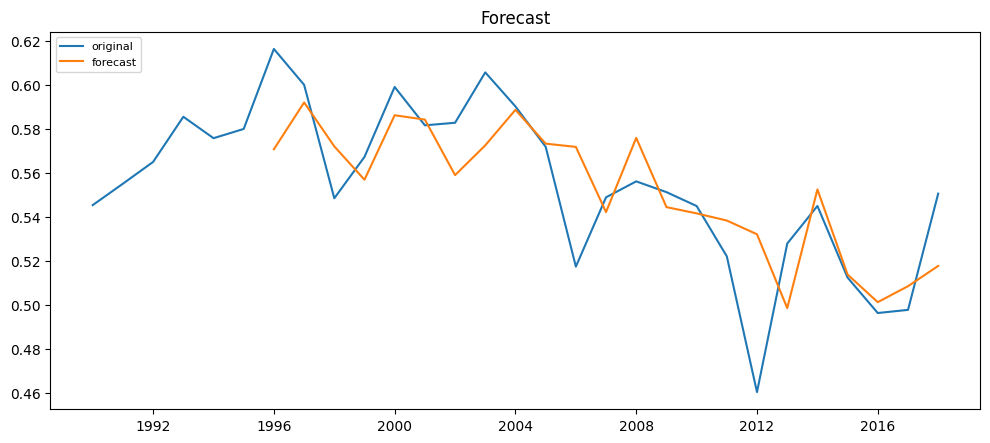

In [509]:
plt.figure(figsize=(12,5), dpi=100)
plt.plot(df, label='original')
#plt.plot(test, label='actual')
plt.plot(final_model_ar.fittedvalues, label='forecast')
plt.title('Forecast')
plt.legend(loc='upper left', fontsize=8)
plt.show()

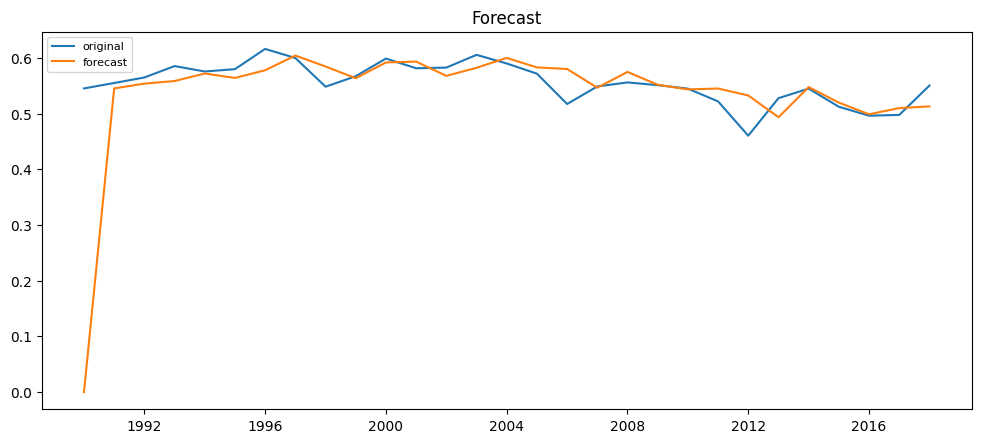

In [505]:
""" plt.figure(figsize=(12,5), dpi=100)
plt.plot(df, label='original')
#plt.plot(test, label='actual')
plt.plot(final_arima.fittedvalues, label='forecast')
plt.title('Forecast')
plt.legend(loc='upper left', fontsize=8)
plt.show() """

### creating dataframe for future forecasting

In [510]:
future_dates=[df.index[-1]+ DateOffset(years=x)for x in range(0,6)]

In [511]:
future_df=pd.DataFrame(index=future_dates[1:],columns=df.columns)

In [512]:
future_df.tail()

,CO2
2019-01-01,NaN
2020-01-01,NaN
2021-01-01,NaN
2022-01-01,NaN
2023-01-01,NaN


In [513]:
len(future_df)

5

### Forecasting for  next 5 years using Final AR model

In [ ]:
""" future_df['CO2'] = final_arima.predict(start = 29, end = 34, dynamic= True)  
#future_df[['CO2', 'forecast']].plot(figsize=(12, 8))
#plt.title('Forecast for next 5 years') """

In [515]:
future_df['CO2'] =final_model_ar.predict(start = 29, end = 34, dynamic= True)  
#future_df[['CO2', 'forecast']].plot(figsize=(12, 8))
#plt.title('Forecast for next 5 years')


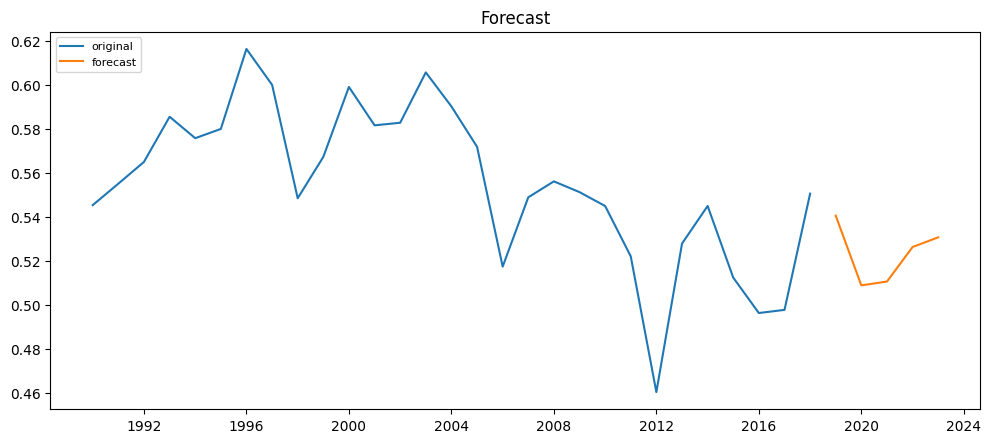

In [516]:
plt.figure(figsize=(12,5), dpi=100)
plt.plot(df, label='original')
#plt.plot(test, label='actual')
plt.plot(future_df['CO2'], label='forecast')
plt.title('Forecast')
plt.legend(loc='upper left', fontsize=8)
plt.show()

In [517]:
df.tail()

,CO2
Year,
2014-01-01,0.54508
2015-01-01,0.51254
2016-01-01,0.49647
2017-01-01,0.49790
2018-01-01,0.55068


In [518]:
future_df.tail()

,CO2
2019-01-01,0.540680
2020-01-01,0.509026
2021-01-01,0.510766
2022-01-01,0.526454
2023-01-01,0.530839


In [519]:
# Exporting to csv file
future_df.to_csv(r'forecast_buildings_data_5years.csv',index=True)

## Forecast for 10 years

In [520]:
future_dates_10=[df.index[-1]+ DateOffset(years=x)for x in range(0,11)]
future_df_10=pd.DataFrame(index=future_dates_10[1:],columns=df.columns)
future_df_10.tail()
len(future_df_10)

10

In [521]:
future_df_10['CO2'] = final_model_ar.predict(start = 29, end = 39, dynamic= True) 

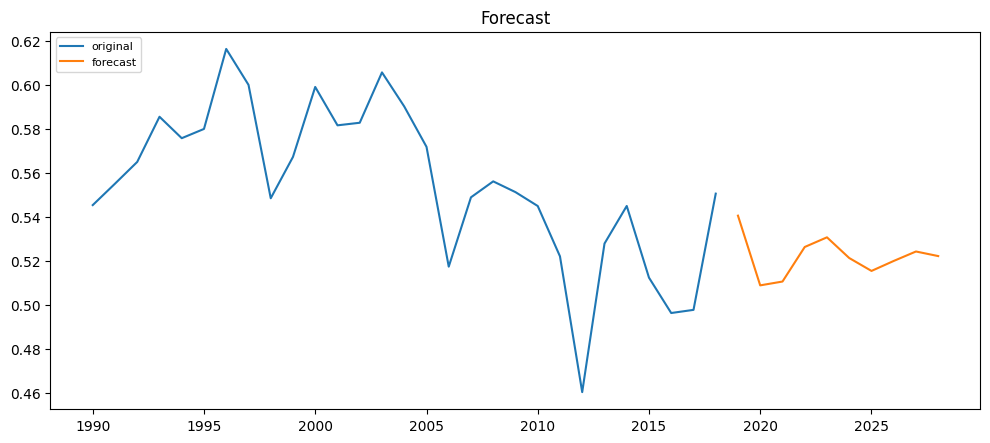

In [522]:
plt.figure(figsize=(12,5), dpi=100)
plt.plot(df, label='original')
#plt.plot(test, label='actual')
plt.plot(future_df_10['CO2'], label='forecast')
plt.title('Forecast')
plt.legend(loc='upper left', fontsize=8)
plt.show()

In [523]:
future_df_10

,CO2
2019-01-01,0.540680
2020-01-01,0.509026
2021-01-01,0.510766
2022-01-01,0.526454
2023-01-01,0.530839
2024-01-01,0.521450
2025-01-01,0.515584
2026-01-01,0.520116
2027-01-01,0.524409
2028-01-01,0.522328


In [524]:
# Exporting to csv file
future_df_10.to_csv(r'forecast_data_buildings_10years.csv',index=True)

In [525]:
# Saving the pickle file
import pickle
pickle.dump(final_arima, open('Forecast_AR_buildings.pkl','wb'))